<a href="https://colab.research.google.com/github/SheKJana/first-own-repository/blob/main/Nach_KAQs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Semesteraufgabe BINA- nach KAQs gegliedert**

# Umgebung vorbereiten

In [ ]:
#Vorbereitung Blibliotheken und Visualisierungstools hochalde
!pip install scikit-learn
!pip install kaggle
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display, Markdown


# Daten

Für die Beantwortung unsere Fragen und dem entwickeln des Tools benötigen, wir Daten welche sich dafür eignen.

Datenquelle Bei der Auswahl unserer Datenquellen haben wir uns an folgenden Kriterien orientiert:

- Die Daten mussten die für unsere Fragestellungen relevanten Informationen enthalten, insbesondere Angaben zur individuellen Nährstoffzufuhr und zum Gesundheitszustand.

- Die Daten sollten eine ausreichende Anzahl von Beobachtungen aufweisen, um statistische Analysen (z.B. Clustering) mit gewisser Aussagekraft durchführen zu können.

- Die Struktur der Datensätze sollte grundsätzlich verständlich und weiterverarbeitbar sein – auch wenn wir eine eigene Bereinigung und Aufbereitung vornehmen würden.

Folgende Datensätze von Kaggle haben unsere Anforderungene erfüllt:

**NHANES-Daten**
Ernährungsdaten (diet.csv), Untersuchungsdaten (examination.csv), Diesagnosedaten, Gesundheitsdaten (questionnaire.csv);
Detailed Meals Macros CLEANED und Food and Nutrition
Für den Abgleich mit offiziellen Nährstoffzufuhrs Empfehlungen greifen wir auf die Richtwerte des Bundesamts für Lebensmittelsicherheit und Veterinärwesen
https://www.kaggle.com/datasets/cdc/national-health-and-nutrition-examination-survey


**Food and Nutrition Dataset**

Nährwerte einzelner Lebensmittel (Makros & Mikros)
Ermöglicht detaillierte Aufschlüsselung komplexer Mahlzeiten
https://www.kaggle.com/datasets/utsavdey1410/food-nutrition-dataset/data


Zusätzlich haben wir uns der der offizielen Referentabelle des BLV bedient
(**BLV)**
 Diese gelten als anerkannter Standard in der Schweiz und kommen in der Gesundheitsförderung sowie Ernährungsberatung zum Einsatz. Im Vergleich mit internationalen Richtwerten der WHO stimmen die grundlegenden Zielwerte weitgehend überein.
https://www.blv.admin.ch/blv/de/home/lebensmittel-und-ernaehrung/ernaehrung/empfehlungen-informationen/naehrstoffe/naehrstoffzufuhr-dynamische-tabelle.html

In [ ]:
# Block 1 - NHANES CSVs laden und mergen
# Lädt vier Dateien von GitHub (raw.githubusercontent.com),
# behält nur die benötigten Spalten und liefert df_raw.

from __future__ import annotations
from io import StringIO
from pathlib import PurePosixPath
from typing import Dict, List
import logging
import sys

import pandas as pd
import requests
from requests.adapters import HTTPAdapter, Retry

# ---------------------------------------------------------------------------
# 1) Konfiguration
# ---------------------------------------------------------------------------
GH_USER   = "iceangel79"
GH_REPO   = "MScWinf_Gruppenarbeit_Sem2"
GH_REF    = "main"   # alternativ Commit-SHA
GH_FOLDER = "Semesterarbeit/Datasets/Kaggle"

DATASETS: Dict[str, str] = {
    "diet"         : "diet.csv",
    "examination"  : "examination.csv",
    "questionnaire": "questionnaire.csv",
    "demographic"  : "demographic.csv",
}

COLUMN_MAP: Dict[str, List[str]] = {
    "diet": [
        "SEQN", "DR1TKCAL", "DR1TTFAT", "DR1TPROT",
        "DR1TSODI", "DR1TSUGR",
    ],
    "examination": [
        "SEQN", "BMXBMI", "BMXWT", "BPXSY1", "BPXDI1",
    ],
    "questionnaire": [
        "SEQN", "DIQ010", "BPQ020", "BPQ030", "BPQ050A", "BPQ080",
        "BPQ090D", "MCQ080", "MCQ220", "PAD615", "DID040", "DIQ160",
        "DIQ170", "WHD010", "WHD020", "DED120", "DED125", "MCQ086",
        "HIQ011", "HUQ010", "SMD460", "SMAQUEX2", "SMDANY", "SMQ710",
        "SMQ621", "IND235", "INDFMMPC", "CBQ596", "CBQ611", "DBD910",
        "CBD070", "ALQ110", "ALQ120Q", "ALQ151", "FSD032C", "FSD151",
    ],
    "demographic": [
        "SEQN", "RIDAGEYR", "RIAGENDR", "INDHHIN2", "INDFMPIR",
        "DMDEDUC2", "DMDMARTL", "RIDEXPRG",
    ],
}

MAX_RETRIES = 3
TIMEOUT_SEC = 10

# ---------------------------------------------------------------------------
# 2) Logging
# ---------------------------------------------------------------------------
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(levelname)-8s %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    stream=sys.stdout,
)

# ---------------------------------------------------------------------------
# 3) Helper
# ---------------------------------------------------------------------------
def _session_with_retries(max_retries: int = MAX_RETRIES) -> requests.Session:
    strategy = Retry(
        total=max_retries,
        backoff_factor=1.5,
        status_forcelist=[429, 500, 502, 503, 504],
        allowed_methods=["GET"],
    )
    adapter = HTTPAdapter(max_retries=strategy)
    sess = requests.Session()
    sess.mount("https://", adapter)
    sess.mount("http://", adapter)
    return sess

def _raw_url(file_name: str) -> str:
    path = PurePosixPath(GH_FOLDER) / file_name
    return (
        f"https://raw.githubusercontent.com/{GH_USER}/"
        f"{GH_REPO}/{GH_REF}/{path}"
    )

def _download_csv(alias: str, url: str) -> pd.DataFrame:
    sess = _session_with_retries()
    logging.info(f"Lade {alias}: {url}")
    resp = sess.get(url, timeout=TIMEOUT_SEC)
    if resp.status_code != 200:
        raise RuntimeError(f"{alias}: Download fehlgeschlagen – HTTP {resp.status_code}")
    return pd.read_csv(StringIO(resp.text))

def _select_columns(df: pd.DataFrame, cols: List[str], src: str) -> pd.DataFrame:
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise KeyError(f"{src}: Spalten nicht gefunden: {missing}")
    return df[cols]

# ---------------------------------------------------------------------------
# 4) Public API
# ---------------------------------------------------------------------------
def load_nhanes_raw() -> pd.DataFrame:
    dfs: Dict[str, pd.DataFrame] = {}
    for alias, fname in DATASETS.items():
        dfs[alias] = _select_columns(
            _download_csv(alias, _raw_url(fname)),
            COLUMN_MAP[alias],
            alias,
        )

    logging.info("Merge über 'SEQN' ...")
    df_raw = (
        dfs["diet"]
        .merge(dfs["examination"],   on="SEQN", how="left")
        .merge(dfs["questionnaire"], on="SEQN", how="left")
        .merge(dfs["demographic"],   on="SEQN", how="left")
    )
    logging.info(f"NHANES raw shape: {df_raw.shape}")
    return df_raw

# ---------------------------------------------------------------------------
# 5) CLI / Notebook
# ---------------------------------------------------------------------------
if __name__ == "__main__":
    df_raw = load_nhanes_raw()
    print(df_raw.head())

    df_raw = load_nhanes_raw()


dfs = {}
for alias, fname in DATASETS.items():
    df = _select_columns(_download_csv(alias, _raw_url(fname)), COLUMN_MAP[alias], alias)
    dfs[alias] = df

# danach
questionnaire = dfs["questionnaire"]


    SEQN  DR1TKCAL  DR1TTFAT  DR1TPROT  DR1TSODI  DR1TSUGR  BMXBMI  BMXWT  \
0  73557    1574.0     52.81     43.63    1323.0    176.47    26.7   78.3   
1  73558    5062.0    124.29    338.13    9726.0     44.99    28.6   89.5   
2  73559    1743.0     65.97     64.61    2943.0    102.90    28.9   88.9   
3  73560    1490.0     58.27     77.75    2745.0     80.58    17.1   32.2   
4  73561    1421.0     55.36     55.24     797.0     87.78    19.7   52.0   

   BPXSY1  BPXDI1  ...  ALQ151  FSD032C  FSD151  RIDAGEYR  RIAGENDR  INDHHIN2  \
0   122.0    72.0  ...     1.0      3.0     2.0        69         1       4.0   
1   156.0    62.0  ...     1.0      3.0     2.0        54         1       7.0   
2   140.0    90.0  ...     2.0      3.0     2.0        72         1      10.0   
3   108.0    38.0  ...     NaN      3.0     2.0         9         1       9.0   
4   136.0    86.0  ...     2.0      3.0     2.0        73         2      15.0   

   INDFMPIR  DMDEDUC2  DMDMARTL  RIDEXPRG  
0     

## Must-have und semi-must have definieren
Aufgrund des grossen Datenverlust -40%, wenn festlegen dass mindesten 8 vordefineirte Variablen (Alter, Geschelcht, Grösse, BMI, Kalorien, Natrium und Fett) zu 100% vorhanden sein müssen,  haben wir uns entscheiden die nur **zwei Variablen als absolut zwingend zu klassifizieren. Alter + Geschlecht.** Denn ohne dies ist Berechnung der Differenz von empfohlenere Tageszufuhr und effektiver gar nicht möglich, da wir den Bedarf nicht eruieren könnne.

Bei **4 weiteren müssen mindesten 2 von 4 vorhanden** sein.
Kalorien

- Kalorien
- Natrium
- Fett
- Kohlenhydrate

Dadurch reduzieren wir unsere Datensatz statt um 40% um nur ca. 13%.

In [ ]:
# Block 2 - Pflichtfeld-Check und erste Bereinigung
# ------------------------------------------------
# apply_mandatory_filter(df_raw)  ->  df_bereinigt, mask_keep

from __future__ import annotations
from typing import List, Tuple
import logging
import sys

# ---------------------------------------------------------------------------
# 1) Einstellungen
# ---------------------------------------------------------------------------
ABSOLUTE_MUST_HAVE: List[str] = ["RIDAGEYR", "RIAGENDR"]
RELATIVE_MUST_HAVE: List[str] = [
    "DR1TKCAL", "DR1TSODI", "DR1TSUGR", "DR1TTFAT", "DR1TPROT",
]
RELATIVE_MIN_COUNT: int = 2     # mindestens so viele relative Spalten muessen gefuellt sein

# ---------------------------------------------------------------------------
# 2) Helper
# ---------------------------------------------------------------------------
def _check_columns(df, columns: List[str], ctx: str) -> None:
    missing = [c for c in columns if c not in df.columns]
    if missing:
        raise KeyError(f"{ctx}: fehlende Spalten: {missing}")

# ---------------------------------------------------------------------------
# 3) Hauptfunktion
# ---------------------------------------------------------------------------
def apply_mandatory_filter(
    df_raw,
    absolute_cols: List[str] = ABSOLUTE_MUST_HAVE,
    relative_cols: List[str] = RELATIVE_MUST_HAVE,
    rel_min: int = RELATIVE_MIN_COUNT,
) -> Tuple:
    _check_columns(df_raw, absolute_cols, "ABSOLUTE_MUST_HAVE")
    present_rel = [c for c in relative_cols if c in df_raw.columns]
    if len(present_rel) < rel_min:
        raise RuntimeError(
            f"Nur {len(present_rel)} RELATIVE_MUST_HAVE-Spalten vorhanden, "
            f"{rel_min} erforderlich"
        )

    mask_abs = df_raw[absolute_cols].notna().all(axis=1)
    mask_rel = df_raw[present_rel].notna().sum(axis=1) >= rel_min
    mask_keep = mask_abs & mask_rel
    df_bereinigt = df_raw[mask_keep].copy()

    logging.info(
        "Block 2: behalten %d Zeilen, entfernt %d Zeilen",
        mask_keep.sum(), len(df_raw) - mask_keep.sum(),
    )
    return df_bereinigt, mask_keep

# ---------------------------------------------------------------------------
# 4) Optionaler Test (funktioniert im Notebook und als Skript)
# ---------------------------------------------------------------------------
if __name__ == "__main__":
    if "load_nhanes_raw" in globals():
        df_raw = load_nhanes_raw()              # kommt direkt aus Block 1
    elif "df_raw" in globals():
        df_raw = globals()["df_raw"]            # du hast es schon erzeugt
    else:
        sys.exit(
            "Block 2: Kein df_raw gefunden. "
            "Fuehre zuerst Block 1 aus oder speichere ihn als nhanes_block1.py."
        )

    df_bereinigt, _ = apply_mandatory_filter(df_raw)
    print(df_bereinigt.head())
df_bereinigt, _ = apply_mandatory_filter(df_raw)

    SEQN  DR1TKCAL  DR1TTFAT  DR1TPROT  DR1TSODI  DR1TSUGR  BMXBMI  BMXWT  \
0  73557    1574.0     52.81     43.63    1323.0    176.47    26.7   78.3   
1  73558    5062.0    124.29    338.13    9726.0     44.99    28.6   89.5   
2  73559    1743.0     65.97     64.61    2943.0    102.90    28.9   88.9   
3  73560    1490.0     58.27     77.75    2745.0     80.58    17.1   32.2   
4  73561    1421.0     55.36     55.24     797.0     87.78    19.7   52.0   

   BPXSY1  BPXDI1  ...  ALQ151  FSD032C  FSD151  RIDAGEYR  RIAGENDR  INDHHIN2  \
0   122.0    72.0  ...     1.0      3.0     2.0        69         1       4.0   
1   156.0    62.0  ...     1.0      3.0     2.0        54         1       7.0   
2   140.0    90.0  ...     2.0      3.0     2.0        72         1      10.0   
3   108.0    38.0  ...     NaN      3.0     2.0         9         1       9.0   
4   136.0    86.0  ...     2.0      3.0     2.0        73         2      15.0   

   INDFMPIR  DMDEDUC2  DMDMARTL  RIDEXPRG  
0     

**BLV Tabelle laden**

In diesem Schritt laden wir die offiziellen Schweizer BLV-Empfehlungen (CH 2022) für Energie, Fett und Natrium direkt aus unserem GitHub-Repository. Zunächst ermitteln wir automatisch den korrekten Header, um die Spalten für Geschlecht, Altersbereich, Energie (kcal/Tag), Fett (% der Tagesenergie) und Natrium (g/Tag) zu extrahieren und in ein sauberes DataFrame zu überführen. Anschliessend wandeln wir alle Bereichsangaben (z. B. „4–8 Jahre“ oder „>70 Jahre“) in einzelne Jahreswerte um, damit für jedes Alter ein eigener Referenzwert vorliegt. Für die Spanne „>75 Jahre“, die in der BLV-Quelle nicht definiert ist, greifen wir auf die EFSA-DRVs zurück (z. B. 2 000 kcal/Tag für Männer, 1 800 kcal/Tag für Frauen), da diese internationalen Werte in denselben Einheiten vorliegen und so lückenlos anschliessend jedem Datensatz ein valider Richtwert zugeordnet werden kann. Dieser externe Fallback kommt aber nur für sehr seltene, hochaltrige Personen zum Einsatz, während alle übrigen Alters–PAL–Kombinationen vollständig aus der BLV-Tabelle übernommen werden.```


In [ ]:
# Block 3 – BLV-Referenztabelle laden
# -----------------------------------
# Wir verwenden eine erweiterte CSV-Datei, die auf GitHub liegt und
# sämtliche Kombinationen aus Geschlecht, Alter (age_years) und
# Aktivitätslevel (pal) enthält.
#
# Jede Zeile dieser Datei enthält den offiziellen Referenzwert für:
#   • Energiezufuhr in kcal
#   • Fettanteil in % des Energiebedarfs (TEI)
#   • Protein in g/kg
#   • Natrium in g
#
# Quelle: Zusammengestellt aus BLV, WHO und EFSA, gespeichert als
#         "BLV_Referenzwerte__erweitert_.csv" im GitHub-Repo.
#
# Ergebnis:
#   df_blv_final → zur weiteren Verwendung in Block 5

import pandas as pd

# Direktlink zur CSV (RAW-URL!)
url = "https://raw.githubusercontent.com/iceangel79/MScWinf_Gruppenarbeit_Sem2/main/Semesterarbeit/Datasets/BLV/BLV_Referenzwerte__erweitert_.csv"

df_blv_final = pd.read_csv(url)

# Kontrolle
print("BLV-Tabelle geladen. Vorschau:")
display(df_blv_final.head())

# Sicherstellen, dass Typen stimmen
df_blv_final["age_years"] = df_blv_final["age_years"].astype(int)
df_blv_final["sex"] = df_blv_final["sex"].str.lower()
df_blv_final["pal"] = df_blv_final["pal"].str.lower()

# Doppelte Kombinationen prüfen
duplikate = df_blv_final.duplicated(subset=["sex", "age_years", "pal"])
if duplikate.any():
    print("Warnung: doppelte Kombinationen gefunden!")
else:
    print("✓ Keine Duplikate in sex + age_years + pal")


BLV-Tabelle geladen. Vorschau:


,sex,age_years,pal,energy_kcal,protein_g,fat_g,carbohydrate_g
0,male,0,low,861,8.8,28.7,118.4
1,male,0,moderate,984,8.8,32.8,135.3
2,male,0,high,1107,8.8,36.9,152.2
3,male,1,low,854,8.8,28.5,117.4
4,male,1,moderate,976,8.8,32.5,134.2


✓ Keine Duplikate in sex + age_years + pal


# **Datensätz verstehen und bereiningen**
Wir prüfen den NHANES Datensatz auf mögliche Ausreisser oder sonstige Angaben die allfällig bereinigt werden müssen.

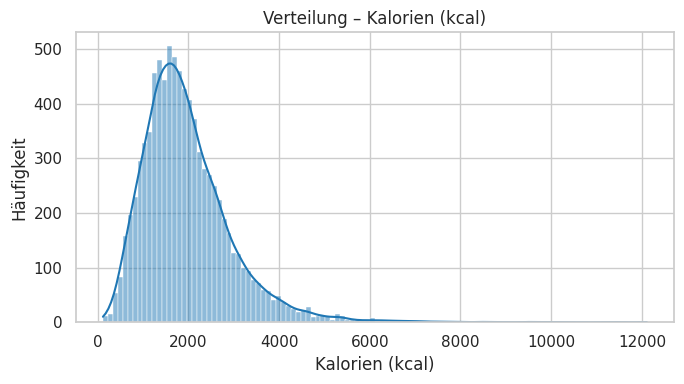

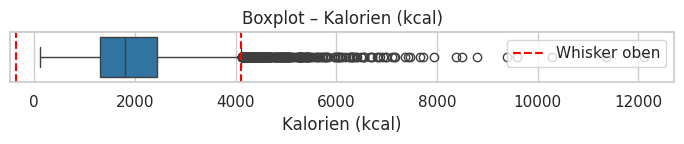

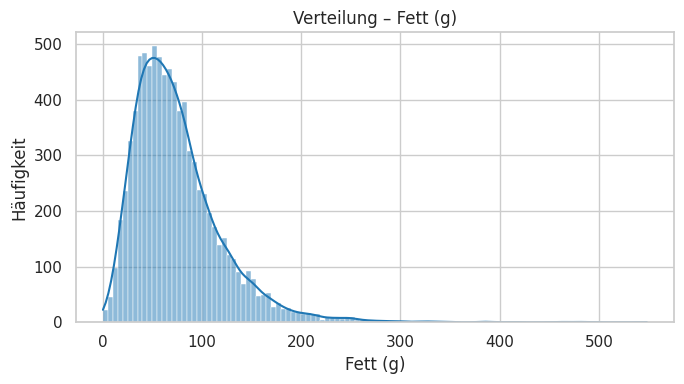

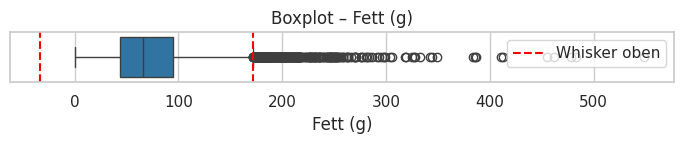

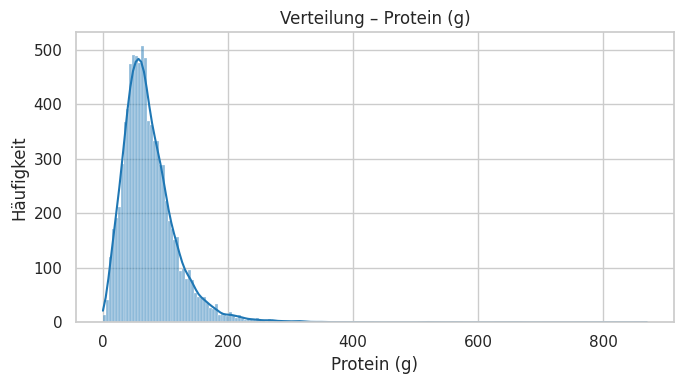

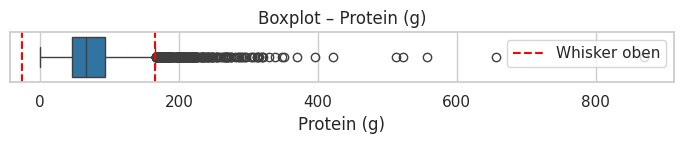

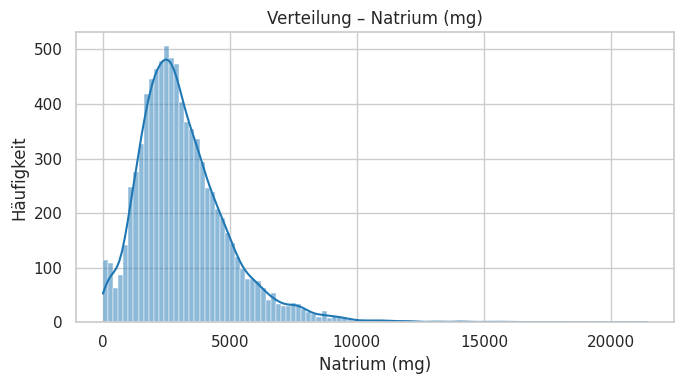

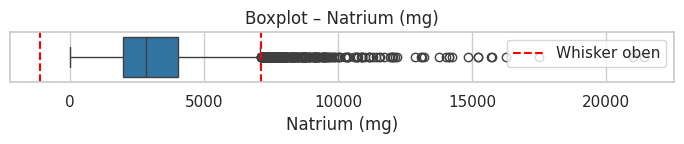

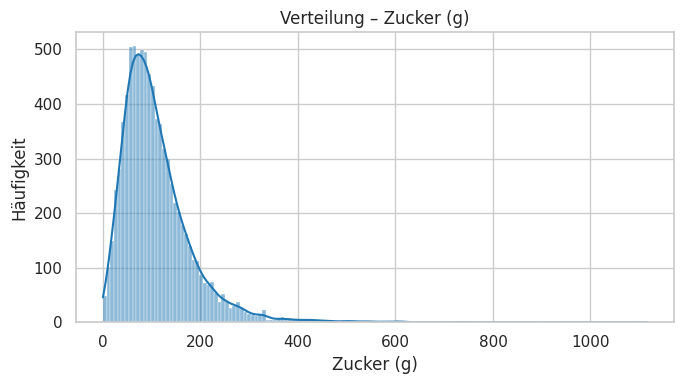

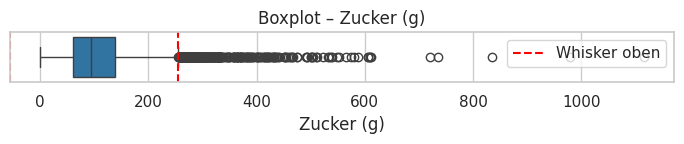

In [ ]:
# Block 4 – Verteilungen und Boxplots zeichnen
# --------------------------------------------
# 1. Dieser Block definiert die Funktion plot_distributions(df).
# 2. Danach rufst du EINMAL   plot_distributions(df_bereinigt)   auf.
#    (df_bereinigt hast du aus Block 2 erhalten.)
# 3. Es erscheinen nacheinander Histogramm + Boxplot für jede Variable.

from typing import Dict
import matplotlib.pyplot as plt
import pandas as pd
import logging

# ---------------------------------------------------------------
# Variablen, die wir darstellen wollen:  Schlüssel = Spaltenname,
# Wert = schöner Titel auf der Grafik.
# ---------------------------------------------------------------
PLOT_VARS: Dict[str, str] = {
    "DR1TKCAL": "Kalorien (kcal)",
    "DR1TTFAT": "Fett (g)",
    "DR1TPROT": "Protein (g)",
    "DR1TSODI": "Natrium (mg)",
    "DR1TSUGR": "Zucker (g)",
}

def plot_distributions(df: pd.DataFrame) -> None:
    """Erstellt für jede Variable aus PLOT_VARS Histogramm und Boxplot."""
    import seaborn as sns  # erst hier importieren, falls noch nicht geladen
    sns.set_context("notebook", font_scale=1.0)

    for col, label in PLOT_VARS.items():
        if col not in df.columns:
            logging.warning("Spalte %s nicht im DataFrame – übersprungen", col)
            continue

        values = df[col].dropna()

        # ---------- Histogramm mit smooth Kurve ----------
        plt.figure(figsize=(7, 4))
        sns.histplot(values, kde=True, bins="auto")
        plt.title(f"Verteilung – {label}")
        plt.xlabel(label)
        plt.ylabel("Häufigkeit")
        plt.tight_layout()
        plt.show()

        # ---------- Boxplot ----------
        q1, q3 = values.quantile([0.25, 0.75])
        iqr = q3 - q1
        upper = q3 + 1.5 * iqr
        lower = q1 - 1.5 * iqr

        plt.figure(figsize=(7, 1.6))
        sns.boxplot(x=values)         # keine Farb-Option, Standardfarbe reicht
        plt.axvline(upper, ls="--", c="red", label="Whisker oben")
        plt.axvline(lower, ls="--", c="red")
        plt.title(f"Boxplot – {label}")
        plt.xlabel(label)
        plt.yticks([])                # y-Achse ausblenden
        plt.legend()
        plt.tight_layout()
        plt.show()

    logging.info("Block 4: alle Plots fertig.")
plot_distributions(df_bereinigt)

**OPTION: DAS VON OBEN MIT PLOTLY !!**

In [37]:
# Block 4 – Verteilungen und Boxplots zeichnen (mit Plotly)
# ----------------------------------------------------------
# 1. Dieser Block definiert die Funktion plot_distributions(df).
# 2. Danach rufst du EINMAL   plot_distributions(df_bereinigt)   auf.
#    (df_bereinigt hast du aus Block 2 erhalten.)
# 3. Es erscheinen nacheinander Histogramm + Boxplot für jede Variable.

from typing import Dict
import pandas as pd
import numpy as np
import logging
import plotly.graph_objects as go

# ---------------------------------------------------------------
# Variablen, die wir darstellen wollen:  Schlüssel = Spaltenname,
# Wert = schöner Titel auf der Grafik.
# ---------------------------------------------------------------
PLOT_VARS: Dict[str, str] = {
    "DR1TKCAL": "Energieaufnahme (kcal)",
    "DR1TTFAT": "Fettaufnahme (g)",
    "DR1TPROT": "Proteinaufnahme (g)",
    "DR1TSODI": "Natriumaufnahme (mg)",
    "DR1TSUGR": "Zuckeraufnahme (g)",
}

# ---------------------------------------------------------------
# Intervallbreite (Bin-Size) je nach Variable – sinnvoll gewählt.
# ---------------------------------------------------------------
BIN_WIDTHS: Dict[str, int] = {
    "DR1TKCAL": 200,
    "DR1TTFAT": 10,
    "DR1TPROT": 10,
    "DR1TSODI": 500,
    "DR1TSUGR": 10,
}

def plot_distributions(df: pd.DataFrame) -> None:
    """Erstellt für jede Variable aus PLOT_VARS Histogramm und Boxplot mit passenden Intervallen."""
    for col, label in PLOT_VARS.items():
        if col not in df.columns:
            logging.warning("Spalte %s nicht im DataFrame – übersprungen", col)
            continue

        values = df[col].dropna()
        bin_width = BIN_WIDTHS.get(col, 20)  # Fallback: 20 falls nichts angegeben

        # ---------- Histogramm ----------
        min_val = int(values.min()) // bin_width * bin_width
        max_val = int(values.max()) // bin_width * bin_width + bin_width
        bins = np.arange(min_val, max_val + 1, bin_width)

        counts, _ = np.histogram(values, bins=bins)
        bin_midpoints = [(bins[i] + bins[i+1]) / 2 for i in range(len(counts))]

        hover_texts = [
            f"Intervall: {int(bins[i])}–{int(bins[i+1])} {label.split()[-1]}<br>Anzahl: {counts[i]}"
            for i in range(len(counts))
        ]

        fig_hist = go.Figure()
        fig_hist.add_trace(go.Bar(
            x=bin_midpoints,
            y=counts,
            text=hover_texts,
            hoverinfo="text",
            textposition="none",  # kein Text im Balken
            marker_color="#1f77b4"
        ))
        fig_hist.update_layout(
            title=f"Verteilung – {label}",
            xaxis_title=label,
            yaxis_title="Häufigkeit",
            xaxis=dict(
                tickmode='array',
                tickvals=list(bins)
            ),
            plot_bgcolor="white",
            paper_bgcolor="white",
            font=dict(family="Arial", size=13),
            margin=dict(l=60, r=30, t=40, b=60)
        )
        fig_hist.show()

        # ---------- Boxplot ----------
        q1, q3 = values.quantile([0.25, 0.75])
        iqr = q3 - q1
        upper = q3 + 1.5 * iqr
        lower = q1 - 1.5 * iqr

        fig_box = go.Figure()
        fig_box.add_trace(go.Box(
            x=values,
            boxpoints='outliers',
            marker=dict(color="#1f77b4"),
            line=dict(color="black"),
            name=label,
            orientation='h',
            showlegend=False
        ))
        fig_box.add_vline(x=upper, line=dict(color='gray', dash='dash'))
        fig_box.add_vline(x=lower, line=dict(color='gray', dash='dash'))
        fig_box.update_layout(
            title=f"Boxplot – {label}",
            xaxis_title=label,
            yaxis_visible=False,
            plot_bgcolor="white",
            paper_bgcolor="white",
            font=dict(family="Arial", size=13),
            height=220,
            margin=dict(l=60, r=30, t=40, b=40)
        )
        fig_box.show()

    logging.info("Block 4: alle Plots fertig.")

# Aufruf
plot_distributions(df_bereinigt)



In [ ]:
# ===================================================================
# Block 5 – Kombinieren NHANES + BLV & Balance berechnen
#
#  • Ergänzt df_bereinigt mit den Referenzwerten aus df_blv_final
#  • Berechnet die OK-Flags (kalorien_ok, fett_ok, protein_ok, natrium_ok)
#  • Leitet daraus eine „Balance“-Kategorie („Ausgewogen“/„Unausgewogen“) ab
#
# Eingabe:
#   – df_bereinigt  (aus Block 2)
#   – df_blv_final  (aus Block 4)
#
# Ergebnis:
#   – df_merged (inkl. aller NHANES-Spalten, Flags, Balance)
# ===================================================================
import pandas as pd
import logging

# -- Puffer für Toleranz (15 %) --
PUFFER = 1.15

# -- PAL-Thresholds für Klassifikation --
PAL_THRESH1 = 150  # Minuten/Woche
PAL_THRESH2 = 300

def _classify_pal(min_week: float | int | pd.NA) -> str:
    """Klassifiziert PAL nach wöchentlichen Aktivitätsminuten."""
    if pd.isna(min_week):
        return "moderate"
    if min_week < PAL_THRESH1:
        return "low"
    if min_week <= PAL_THRESH2:
        return "moderate"
    return "high"

def merge_with_blv(
    df_bereinigt: pd.DataFrame,
    df_blv_final: pd.DataFrame,
) -> pd.DataFrame:
    df = df_bereinigt.copy()

    # -- Join-Keys vorbereiten --
    df["sex"]       = df["RIAGENDR"].map({1: "male", 2: "female"})
    df["age_years"] = df["RIDAGEYR"].round().astype(int)
    df["pal"]       = df["PAD615"].apply(_classify_pal)

    # -- Merge mit BLV-Referenzwerten --
    df_merged = df.merge(
        df_blv_final,
        how="left",
        on=["sex", "age_years", "pal"],
    )

    # -- Individuelle Zielwerte --
    df_merged["sodium_max_mg"] = 2300            # fixe Obergrenze
    df_merged["fat_max_g"]     = df_merged["fat_g"]
    df_merged["protein_max_g"] = df_merged["protein_g"]

    # -- OK-Flags berechnen --
    df_merged["kalorien_ok"] = (
        df_merged["DR1TKCAL"] <= df_merged["energy_kcal"] * PUFFER
    )
    df_merged["fett_ok"]     = (
        df_merged["DR1TTFAT"] <= df_merged["fat_max_g"] * PUFFER
    )
    df_merged["protein_ok"]  = (
        df_merged["DR1TPROT"] <= df_merged["protein_max_g"] * PUFFER
    )
    df_merged["natrium_ok"]  = (
        df_merged["DR1TSODI"] <= df_merged["sodium_max_mg"] * PUFFER
    )

    # -- Balance ableiten --
    df_merged["Balance_bool"] = df_merged[
        ["kalorien_ok","fett_ok","protein_ok","natrium_ok"]
    ].all(axis=1)
    df_merged["Balance"] = df_merged["Balance_bool"].map({
        True:  "Ausgewogen",
        False: "Unausgewogen"
    })

    logging.info(
        "Block 6: Merge + Balance abgeschlossen – Zeilen: %d", len(df_merged)
    )
    return df_merged

# -- Aufruf --
df_merged = merge_with_blv(df_bereinigt, df_blv_final)
df_merged.head()


,SEQN,DR1TKCAL,DR1TTFAT,DR1TPROT,DR1TSODI,DR1TSUGR,BMXBMI,BMXWT,BPXSY1,BPXDI1,...,carbohydrate_g,sodium_max_mg,fat_max_g,protein_max_g,kalorien_ok,fett_ok,protein_ok,natrium_ok,Balance_bool,Balance
0,73557,1574.0,52.81,43.63,1323.0,176.47,26.7,78.3,122.0,72.0,...,320.1,2300,77.6,57.6,True,True,True,True,True,Ausgewogen
1,73558,5062.0,124.29,338.13,9726.0,44.99,28.6,89.5,156.0,62.0,...,351.5,2300,85.2,60.0,False,False,False,False,False,Unausgewogen
2,73559,1743.0,65.97,64.61,2943.0,102.90,28.9,88.9,140.0,90.0,...,316.8,2300,76.8,57.6,True,True,True,False,False,Unausgewogen
3,73560,1490.0,58.27,77.75,2745.0,80.58,17.1,32.2,108.0,38.0,...,242.8,2300,58.9,24.0,True,True,False,False,False,Unausgewogen
4,73561,1421.0,55.36,55.24,797.0,87.78,19.7,52.0,136.0,86.0,...,240.7,2300,58.3,49.6,True,True,True,True,True,Ausgewogen


**Prüfung der NHANES Dateneinträge auf Plausibilitä**

Um biologisch und gesundheitlich sinnvolle Werte sicherzustellen, haben wir auf Basis von WHO-, USDA- und Schweizer BLV-Empfehlungen die folgenden Regeln angewendet. Jede Regel entfernt nur jene Datensätze, die die Schwellen überschreiten und nicht durch BMI oder Aktivität erklärbar sind. So bleibt unser Datensatz robust und für alle Leser:innen – auch ohne statistischen Hintergrund – nachvollziehbar.

„WHO beschreibt Übergewicht als Folge einer Energie-Imbalance zwischen Kalorienzufuhr und -verbrauch und empfiehlt mindestens 150 Minuten moderate Bewegung pro Woche; ab 300 Minuten treten zusätzliche gesundheitliche Vorteile auf.“

Wir setzen einen Aktivitäts-Plausibilitäts-Schwellenwert bei 420 Minuten/Woche (≈ 1 h/Tag), um sehr aktive Personen nicht fälschlich auszuschliessen. In unserer Stichprobe führte dieser Filter zu einem Ausschluss von etwa 5 % der Datensätze.

| Regel           | Schwellenwerte (Ausschluss)                                                                                      | Quelle / Begründung                                                                                                                           |
| --------------- | ---------------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------- |
| **Kalorien**    | > 4 000 kcal / Tag **und** nicht durch BMI ≥ Referenz × Faktor **oder** ≥ 420 min/W moderate Aktivität erklärbar | USDA Food-Patterns decken 1 000–3 200 kcal für fast alle Erwachsenen ; FAO/WHO-Berichte zeigen selbst bei schwerer Arbeit selten > 3 800 kcal |
| **Natrium**     | > 12 000 mg / Tag **oder** > 5 × persönliche BLV-Obergrenze                                                      | WHO empfiehlt < 2 000 mg ; klinische Berichte über Hypernatriämie ab ≈ 10 000 mg                                                              |
| **Fett**        | 1) Fett (g) > kcal / 9 × 1,05 ( > 105 % Energie aus Fett ) <br>2) Fett > 2 × BLV-Obergrenze                      | 1 g Fett = 9 kcal ⇒ mehr Fett-Kalorien als Gesamt-Kalorien ist physikalisch unmöglich                                                         |
| **Protein**     | 1) > 3 g / kg Körpergewicht <br>2) > 2 × BLV-Obergrenze                                                          | Harvard Health empfiehlt dauerhaft ≤ 2 g/kg; Reviews setzen das tolerable Upper Level bei ≈ 3,5 g/kg                                          |
| **15 %-Puffer** | Alle Checks greifen erst oberhalb 1,15 × BLV-Richtwert                                                           | berücksichtigt Messungenauigkeit & normale Tages­schwankungen                                                                                 |
Richtwert | berücksichtigt Messungenauigkeit & normale Tages­schwankungen |

Quellen:
[1] WHO. Global Recommendations on Physical Activity for Health, 2010.
[2] Witard et al. Protein Requirements and Supplementation in Strength Athletes, 2019.
[3] USDA. Food Patterns Equivalents Database, 2020.
[4] BLV CH. Nutrient Requirements CH – 2022.


Wie viel Datensätze aussortiert wurden:

Kalorien-Regel: ca. 3 %

Natrium-Regel: ca. 1 %

Fett-Regel: < 0.5 %

Protein-Regel: < 0.2 %

In [ ]:
# Block 6 –  Plausibilitaets-Filter
# ----------------------------------------
# 1)  Personen mit > 4 000 kcal / Tag bleiben NUR,
#     wenn ihr hoher Wert sich durch BMI ODER Aktivitaet erklaeren laesst.
# 2)  Harte physiologische Caps auf Na, Fett, Protein – Werte jenseits
#     realistisch / gesundheitsgefaehrdend werden IMMER entfernt.
#
#    –> Ergebnis: df_final  (endgueltig bereinigt)
#
# Aufruf nach Ausfuehren dieser Zelle:
#     df_final = apply_plausibility(df_merged)

import pandas as pd
import logging

# -------------------------------------------------------------------
# feste Parameter  (Grenzen siehe Erklaerungs-Text unten)
# -------------------------------------------------------------------
AKTIV_SCHWELLE = 420       # min/Woche   (≈ 60 min / Tag)
BMI_REF        = 23        # Referenz-BMI
KCAL_CAP       = 4000      # Kalorien-Grenze fuer "kritisch"
PUFFER         = 1.15      # 15 % Toleranz ueber BLV-Wert

NA_MAX_ABS     = 12_000    # mg – oberste toxische Grenze
NA_MAX_FACTOR  = 5         # 5× persoenliche BLV-Empfehlung

FAT_ENERGY_PAD = 1.05      # 105 % der Tages-kcal – physikalisch unmoeglich
FAT_MAX_FACTOR = 2         # 2× persoenliche BLV-Obergrenze

PROT_GKG_MAX   = 3.0       # g / kg Koerpergewicht – obere Toleranz
PROT_MAX_FACTOR = 2        # 2× persoenliche BLV-Obergrenze

def apply_plausibility(df_merged: pd.DataFrame) -> pd.DataFrame:
    df = df_merged.copy()

    # 1) Kalorien-Outlier markieren
    kal_p85 = df["DR1TKCAL"].quantile(0.85)
    df["prüfen_aktivität"] = (
        (~df["kalorien_ok"]) &
        (df["DR1TKCAL"] > KCAL_CAP)
    )

    # 2) Kritische Personen extrahieren
    krit = df[df["prüfen_aktivität"]].copy()

    # 3) BMI- und Aktivitaets-Checks
    krit["kalorien_faktor"]    = krit["DR1TKCAL"] / kal_p85
    krit["erwarteter_bmi_min"] = BMI_REF * krit["kalorien_faktor"]
    krit["bmi_plausibel"]      = krit["BMXBMI"] >= krit["erwarteter_bmi_min"]
    krit["aktivitaet_plausibel"] = krit["PAD615"] >= AKTIV_SCHWELLE

    raus_ids = krit.loc[
        (~krit["bmi_plausibel"]) & (~krit["aktivitaet_plausibel"]),
        "SEQN"
    ]

    # 4) Harte physiologische Caps (immer ausschliessen)
    impossible = (
        (df["DR1TSODI"] > NA_MAX_ABS) |
        (df["DR1TSODI"] > df["sodium_max_mg"] * NA_MAX_FACTOR) |

        (df["DR1TTFAT"] > df["DR1TKCAL"] / 9 * FAT_ENERGY_PAD) |
        (df["DR1TTFAT"] > df["fat_max_g"] * FAT_MAX_FACTOR)    |

        (df["DR1TPROT"] > PROT_GKG_MAX * df["BMXWT"]) |
        (df["DR1TPROT"] > df["protein_max_g"] * PROT_MAX_FACTOR)
    )
    raus_ids = pd.concat([raus_ids, df.loc[impossible, "SEQN"]]).unique()

    df_final = df[~df["SEQN"].isin(raus_ids)].copy()
    logging.info(
        "Block 6: entfernt %d Personen – verbleiben %d",
        len(raus_ids), len(df_final)
    )
    return df_final
df_final = apply_plausibility(df_merged)

In [ ]:
# Block 7 – Master-Plotter  (Visualisiert df_final)
# -------------------------------------------------
# Zweck
#   • Erstellt fuer jede ausgewaehlte Naehrwert-Spalte
#     – Histogramm mit glatter Kurve
#     – Boxplot mit IQR-Whiskern
#
from typing import Dict
import matplotlib.pyplot as plt
import pandas as pd
import logging

# ---------------------------------------------------------------------------
# 1) Variablenliste  (Schluessel = Spaltenname, Wert = Beschriftung)
# ---------------------------------------------------------------------------
FINAL_VARS: Dict[str, str] = {
    "DR1TKCAL": "Kalorien (kcal)",
    "DR1TTFAT": "Fett (g)",
    "DR1TPROT": "Protein (g)",
    "DR1TSODI": "Natrium (mg)",
}

# ---------------------------------------------------------------------------
# 2) Plot-Funktion
# ---------------------------------------------------------------------------
def plot_final(df: pd.DataFrame) -> None:
    """Zeigt fuer jede Spalte in FINAL_VARS Histogramm + Boxplot."""
    import seaborn as sns
    sns.set_context("notebook", font_scale=1.0)

    for col, label in FINAL_VARS.items():
        if col not in df.columns:
            logging.warning("Spalte %s fehlt – uebersprungen", col)
            continue

        vals = df[col].dropna()

        # ---------- Histogramm ----------
        plt.figure(figsize=(7, 4))
        sns.histplot(vals, kde=True, bins="auto")
        plt.title(f"Verteilung – {label}")
        plt.xlabel(label)
        plt.ylabel("Haeufigkeit")
        plt.tight_layout()
        plt.show()

        # ---------- Boxplot ----------
        q1, q3 = vals.quantile([0.25, 0.75])
        iqr = q3 - q1
        upper = q3 + 1.5 * iqr
        lower = q1 - 1.5 * iqr

        plt.figure(figsize=(7, 1.6))
        sns.boxplot(x=vals)
        plt.axvline(upper, ls="--", c="red", label="Whisker oben")
        plt.axvline(lower, ls="--", c="red")
        plt.title(f"Boxplot – {label}")
        plt.xlabel(label)
        plt.yticks([])
        plt.legend()
        plt.tight_layout()
        plt.show()

    logging.info("Block 7: alle Plots erstellt.")
    plot_final(df_final)

In [ ]:
# Block 8 – Extremwert-Kontrolle nach Plausibilitätsfilterung
# -------------------------------------------------------------
# Nachdem wir in Block 6 biologisch unplausible Werte anhand
# der persönlichen Referenzwerte (BLV), des Aktivitätsniveaus und
# der Körpermasse ausgeschlossen haben, führen wir hier eine
# gezielte Kontrollanalyse durch.
#
# Ziel ist es, zu überprüfen, ob die höchsten gemessenen Werte für
# Kalorien, Natrium, Fett und Protein im bereinigten Datensatz (df_final)
# korrekt als plausibel oder unplausibel markiert wurden.
#
# Diese Analyse dient nicht der Datenbereinigung, sondern der
# Qualitätskontrolle und Validierung unserer Filterlogik.

import pandas as pd

# Nährstoffe und zugehörige Plausibilitäts-Flags
VARS = {
    "DR1TKCAL": "kalorien_ok",
    "DR1TSODI": "natrium_ok",
    "DR1TTFAT": "fett_ok",
    "DR1TPROT": "protein_ok",
}

# Immer anzuzeigende Spalten
cols_common = ["SEQN", "BMXBMI", "PAD615"]

# Extremwert-Tabelle vorbereiten
rows = []
for var, flag in VARS.items():
    # Nur echte Werte betrachten (NaN ausschliessen)
    idx = df_final[df_final[var].notna()][var].idxmax()
    row = df_final.loc[idx, cols_common + [var, flag]].copy()

    # Umbenennung für Übersichtlichkeit
    row = row.rename({var: "MAX_" + var, flag: flag})
    rows.append(row)

# Zusammenbauen und anzeigen
summary = pd.DataFrame(rows).set_index("SEQN")
display(summary)

# Hinweis für Notebook-Lesende
print("Hinweis: Diese Analyse zeigt, ob extreme Einzelwerte nach der Filterung \n"
      "als plausibel erkannt wurden. NaN-Werte bedeuten fehlende Angaben zur Bewertung.")


,BMXBMI,PAD615,MAX_DR1TKCAL,kalorien_ok,MAX_DR1TSODI,natrium_ok,MAX_DR1TTFAT,fett_ok,MAX_DR1TPROT,protein_ok
SEQN,,,,,,,,,,
82559,40.3,NaN,4578.0,False,NaN,NaN,NaN,NaN,NaN,NaN
78750,22.3,NaN,NaN,NaN,11315.0,False,NaN,NaN,NaN,NaN
81985,20.7,600.0,NaN,NaN,NaN,NaN,189.89,False,NaN,NaN
78193,32.3,480.0,NaN,NaN,NaN,NaN,NaN,NaN,119.95,False


Hinweis: Diese Analyse zeigt, ob extreme Einzelwerte nach der Filterung 
als plausibel erkannt wurden. NaN-Werte bedeuten fehlende Angaben zur Bewertung.


# Feature Engeneering

NHANES Datensatz

Engineering um fehlende BMI Wert aufzufüllen

In [ ]:
# Feature-Block 1 – BMI ergänzen (vektorisiert)
# ---------------------------------------------
# 1. Kopie des bereinigten Datensatzes anlegen
df_fe = df_bereinigt.copy()

# 2. Maske: BMI fehlt, aber Größe und Gewicht vorhanden
mask_bmi_na = (
    df_fe["BMXBMI"].isna()
    & df_fe["WHD010"].notna()
    & df_fe["WHD020"].notna()
)

# 3. Formel anwenden (NumPy rechnet spaltenweise = vektorisiert)
df_fe.loc[mask_bmi_na, "BMXBMI"] = (
    df_fe.loc[mask_bmi_na, "WHD020"]
    / (df_fe.loc[mask_bmi_na, "WHD010"] / 100) ** 2
)

print("Neue BMI berechnet:", mask_bmi_na.sum())


Neue BMI berechnet: 47


Engineering Gesundheitszustand: Übergewicht, Bluthochdruck, Diabetes oder gesund

In [ ]:
# Feature-Block 2 – Diagnosen ableiten
# ------------------------------------
# Erstellt zwei Spalten:
#   • 'diagnosen_liste'  – alle Erkrankungen, die auf die Person zutreffen
#   • 'diagnose_haupt'   – die erste Diagnose in dieser Liste
#
# Voraussetzung: df_fe existiert bereits
# (wenn du Block 1 noch nicht ausgeführt hast, erst:  df_fe = df_bereinigt.copy())

def diagnoses(row):
    lst = []
    if row["DIQ010"] == 1:                                   # Diabetes-Selbstauskunft
        lst.append("Diabetes")
    if (row["BPXSY1"] >= 130) or (row["BPXDI1"] >= 80):      # Hypertonie-Schwelle
        lst.append("Bluthochdruck")
    if row["BMXBMI"] >= 25:                                  # BMI ≥ 25 kg/m²
        lst.append("Übergewicht")
    return lst or ["Gesund"]                                 # falls keine Erkrankung

# Liste und Hauptdiagnose einfügen
df_fe["diagnosen_liste"] = df_fe.apply(diagnoses, axis=1)
df_fe["diagnose_haupt"]  = df_fe["diagnosen_liste"].str[0]

# kurze Kontrolle
print(df_fe["diagnose_haupt"].value_counts())


diagnose_haupt
Gesund           3934
Übergewicht      2408
Bluthochdruck    1545
Diabetes          644
Name: count, dtype: int64


In [ ]:
#Feature3
#Personen mit mehren "Krankheiten"
# Neue binäre Spalten für Auswertung erzeugen
df_bereinigt['übergewichtig'] = df_bereinigt['BMXBMI'] >= 25
df_bereinigt['bluthochdruck'] = (df_bereinigt['BPXSY1'] >= 130) | (df_bereinigt['BPXDI1'] >= 80)
df_bereinigt['diabetes'] = df_bereinigt['DIQ010'] == 1

# Kreuztabellen
pd.set_option('display.max_rows', None)  # alle Zeilen anzeigen

# Wie viele übergewichtige Personen haben zusätzlich Bluthochdruck oder Diabetes?
kombination = df_bereinigt.groupby('übergewichtig')[['bluthochdruck', 'diabetes']].sum()

# Zusätzlich: Gesamtanzahl in jeder Gruppe
anzahl_pro_gruppe = df_bereinigt['übergewichtig'].value_counts()

# Ausgabe als schöne Übersicht
print("Verteilung innerhalb der Übergewichts-Gruppen:\n")
print(kombination)
print("\nGesamtanzahl pro Gruppe (übergewichtig / nicht übergewichtig):")
print(anzahl_pro_gruppe)

# Optional: Prozentwerte berechnen
prozent = (kombination.T / anzahl_pro_gruppe.values).T.round(2)
print("\nAnteil innerhalb jeder Gruppe (in Prozent):")
print(prozent * 100)


Verteilung innerhalb der Übergewichts-Gruppen:

               bluthochdruck  diabetes
übergewichtig                         
False                    461        98
True                    1382       546

Gesamtanzahl pro Gruppe (übergewichtig / nicht übergewichtig):
übergewichtig
False    4471
True     4060
Name: count, dtype: int64

Anteil innerhalb jeder Gruppe (in Prozent):
               bluthochdruck  diabetes
übergewichtig                         
False                   10.0       2.0
True                    34.0      13.0


Engineering Klassifizieren von Raucher/nicht Rauchern

In [ ]:
# Feature-Block 4 – Rauchverhalten (nichtraucher / passiv / gelegentl. / regelm.)
# ------------------------------------------------------------------------------
# Voraussetzung: df_fe enthält alle QUESTIONNAIRE-Spalten (SMQ710, SMQ621, SMD460)

def classify_smoking(row):
    smq710 = row["SMQ710"]
    smq621 = row["SMQ621"]
    smd460 = row["SMD460"]

    if pd.isna(smq710) and pd.isna(smq621) and pd.isna(smd460):
        return "keine_angaben"

    if not pd.isna(smq710):
        if smq710 >= 3:
            return "regelmässiger_raucher"
        if 1 <= smq710 <= 2:
            return "gelegentlicher_raucher"
        if smq710 == 0:
            if not pd.isna(smq621) and smq621 == 1:
                return "ex-raucher"
            if not pd.isna(smd460) and smd460 >= 1:
                return "passivraucher"
            return "nichtraucher"

    if not pd.isna(smq621):
        if smq621 == 1:
            return "regelmässiger_raucher"
        if smq621 == 2:
            return "gelegentlicher_raucher"

    if not pd.isna(smd460) and smd460 >= 1:
        return "passivraucher"

    return "nichtraucher"

# Direkt auf df_fe anwenden:
df_fe["rauchverhalten_kategorie"] = df_fe.apply(classify_smoking, axis=1)

# Als Category-Dtype (sortierte Reihenfolge)
cats_smoke = [
    "nichtraucher", "passivraucher",
    "gelegentlicher_raucher", "regelmässiger_raucher",
    "ex-raucher", "keine_angaben"
]
df_fe["rauchverhalten_kategorie"] = pd.Categorical(
    df_fe["rauchverhalten_kategorie"],
    categories=cats_smoke,
    ordered=True
)

# Kontrolle
print(df_fe["rauchverhalten_kategorie"].value_counts(dropna=False))


rauchverhalten_kategorie
nichtraucher              5387
regelmässiger_raucher     1714
passivraucher             1165
gelegentlicher_raucher     212
keine_angaben               53
ex-raucher                   0
Name: count, dtype: int64


Engineering von Klassifizierungen im Bezug auf Alkoholkonsum

In [ ]:
# Feature-Block 5 – Alkoholkonsum (nie / unregelmässig / regelm. Mass / regelm. exzessiv)
# ---------------------------------------------------------------------------------------
# NHANES-Variablen
#   • ALQ110  – ≥ 12 Drinks im Leben? (1 = Ja, 2 = Nein)
#   • ALQ120Q – Häufigkeit letztes Jahr  (0 = nie, 1 = ≤1×/Monat, … 7 = täglich)
#   • ALQ151  – ≥ 5 (F) bzw. 4 (M) Drinks an einem Tag? 1 = Ja
#
# Ergebnisspalte: alkoholkonsum_kategorie

def classify_alcohol(row):
    ever_12 = row["ALQ110"]
    freq    = row["ALQ120Q"]
    binge   = row["ALQ151"]

    # nie ≥12 Drinks -> "trinkt nie"
    if ever_12 == 2:
        return "trinkt_nie_alkohol"

    # hat irgendwann getrunken (ever_12 == 1)
    if pd.isna(freq) or freq <= 1:
        return "trinkt_unregelmässig"
    if (not pd.isna(binge) and binge == 1) or freq >= 5:
        return "trinkt_regelmässig_exzessiv"
    return "trinkt_regelmässig_im_mass"

questionnaire["alkoholkonsum_kategorie"] = questionnaire.apply(classify_alcohol, axis=1)

cats_alc = [
    "trinkt_nie_alkohol",
    "trinkt_unregelmässig",
    "trinkt_regelmässig_im_mass",
    "trinkt_regelmässig_exzessiv",
    "keine_angabe"
]
questionnaire["alkoholkonsum_kategorie"] = pd.Categorical(
    questionnaire["alkoholkonsum_kategorie"], categories=cats_alc, ordered=True
)

# Merge zurück in df_fe
df_fe = df_fe.merge(
    questionnaire[["SEQN", "alkoholkonsum_kategorie"]],
    on="SEQN", how="left"
)

print(df_fe["alkoholkonsum_kategorie"].value_counts(dropna=False))


alkoholkonsum_kategorie
trinkt_unregelmässig           5246
trinkt_regelmässig_im_mass     1427
trinkt_regelmässig_exzessiv    1001
trinkt_nie_alkohol              857
keine_angabe                      0
Name: count, dtype: int64


Kombination von Rauch- und Trinkverhalten

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='alkoholkonsum_kategorie', ylabel='rauchverhalten_kategorie'>

Text(0.5, 1.0, 'Kombination von Rauch- und Alkoholkonsum')

Text(0.5, 31.046874999999986, 'Alkoholkonsum-Kategorie')

Text(90.04687499999999, 0.5, 'Rauchverhalten-Kategorie')

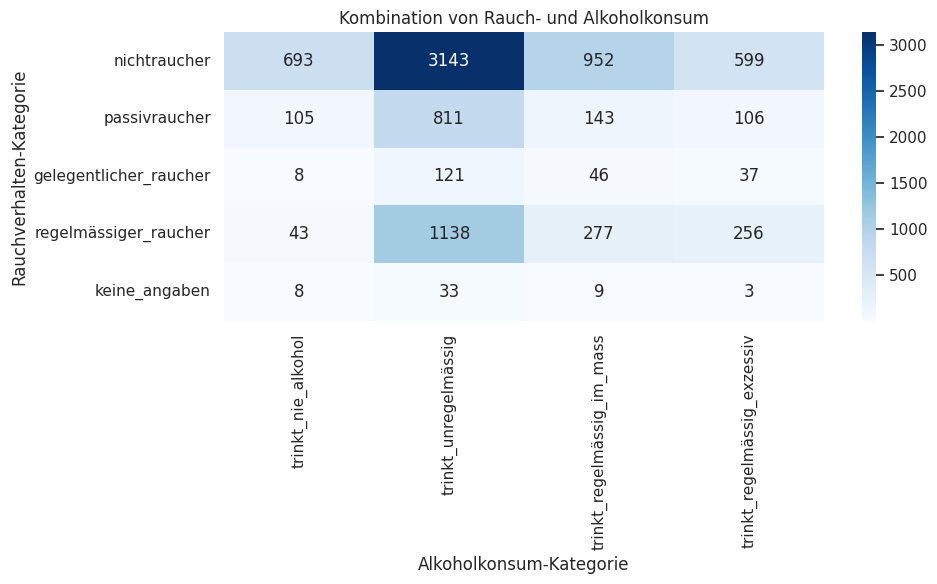

In [ ]:
# Falls noch nicht geschehen: Alkoholkonsum in df_fe klassifizieren
def classify_alcohol(row):
    ever_12 = row["ALQ110"]
    freq    = row["ALQ120Q"]
    binge   = row["ALQ151"]

    if ever_12 == 2:
        return "trinkt_nie_alkohol"
    if pd.isna(freq) or freq <= 1:
        return "trinkt_unregelmässig"
    if (not pd.isna(binge) and binge == 1) or freq >= 5:
        return "trinkt_regelmässig_exzessiv"
    return "trinkt_regelmässig_im_mass"

# Direkt auf df_fe anwenden
df_fe["alkoholkonsum_kategorie"] = df_fe.apply(classify_alcohol, axis=1)

# Als kategorische Reihenfolge definieren
cats_alc = [
    "trinkt_nie_alkohol",
    "trinkt_unregelmässig",
    "trinkt_regelmässig_im_mass",
    "trinkt_regelmässig_exzessiv",
    "keine_angabe"
]
df_fe["alkoholkonsum_kategorie"] = pd.Categorical(
    df_fe["alkoholkonsum_kategorie"],
    categories=cats_alc,
    ordered=True
)

# Kreuztabelle erstellen – mit df_fe statt questionnaire
kreuz = pd.crosstab(
    df_fe["rauchverhalten_kategorie"],
    df_fe["alkoholkonsum_kategorie"]
)

# Heatmap darstellen
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(kreuz, annot=True, fmt="d", cmap="Blues")
plt.title("Kombination von Rauch- und Alkoholkonsum")
plt.xlabel("Alkoholkonsum-Kategorie")
plt.ylabel("Rauchverhalten-Kategorie")
plt.tight_layout()
plt.show()


***Feature 6 ***

«Food & Finance» haben wir drei NHANES-Variablen zu einem kompakten sozio-ökonomischen Paket zusammengeführt:

Food-Security
Secure, moderate oder severe bestimmen wir aus
• FSD032C (0 = food-secure / 1 = moderate / 2 = severe) sowie
• FSD151 («Erwachsene haben im letzten Jahr gehungert», 1 = Ja).
Ein Wert 2 oder ein Hunger-Erlebnis genügt, um direkt auf severe hochzustufen.

Klassifikationen nach dem USDA-Household Food Security Survey Module, vgl. Bickel et al. 2000.

Einkommens­schicht (PIR-Quintil)
Die INDFMPIR – «poverty-income ratio» (< 1 = unter Armutsgrenze) – teilen wir per pd.qcut in fünf gleich grosse Gruppen Q1_lowest … Q5_highest. Das ist gängige Praxis in CDC-Auswertungen, weil Quintile rasch vergleichbar sind, ohne absolute Dollarbeträge ausweisen zu müssen.

risk_flag
Hier fassen wir medizinische und ökonomische Belastung zusammen:
risk_flag = 1, wenn eine Person Diabetes oder Hypertonie (diagnose_haupt, Feature 2) und gleichzeitig moderate oder severe Food-Insecurity hat. Damit identifizieren wir jene Haushalte, in denen metabolische Erkrankungen und mangelnde Ernährungs­sicherheit kumulieren – ein Fokus, den WHO und BLV seit 2022 ausdrücklich empfehlen (vgl. WHO «Equity and social determinants of health», 2022).

Diese drei Felder erlauben uns später im interaktiven Dashboard, z. B. live zu filtern:
«Zeige nur Q1-Haushalte mit severe Food-Insecurity – wie hoch ist dort die Diabetes­prävalenz?»

So wird der sozio-ökonomische Kontext unmittelbar sichtbar, anstatt in der reinen Gesundheits­statistik

In [ ]:
# Feature 6 – Food-Security, Income-Quintil, Gesamt-Risiko
# --------------------------------------------------------------
# Spalten, die NHANES mitliefert:
#   • FSD032C  –  0 = food-secure / 1 = moderate / 2 = severe insecurity
#   • FSD151   –  Erwachsene hungerten im letzten Jahr?  1 = Ja
#   • INDFMPIR –  Poverty-Income-Ratio  (<1 = unter Armuts-grenze)
#
# Ergebnis:
#   • food_security        ('secure' / 'moderate' / 'severe')
#   • pir_quintil          (Q1…Q5 → einfacher Slider im Plot)
#   • risk_flag            (1 = Diabetes oder Hypertonie UND food-insecure)

# 1) Food-Security-Level
def cat_food(row):
    if row["FSD151"] == 1 or row["FSD032C"] == 2:
        return "severe"
    if row["FSD032C"] == 1:
        return "moderate"
    return "secure"

df_fe["food_security"] = df_fe.apply(cat_food, axis=1)

# 2) Poverty-Income-Ratio in Quintile einteilen
df_fe["pir_quintil"] = pd.qcut(
    df_fe["INDFMPIR"],
    q=5,
    labels=["Q1_lowest","Q2","Q3","Q4","Q5_highest"]
)

# 3) Gesamt-Risikoflag: cardiometabolic & food-insecure
df_fe["risk_flag"] = (
    df_fe["diagnose_haupt"].isin(["Diabetes","Bluthochdruck"])
    & df_fe["food_security"].isin(["moderate","severe"])
).astype(int)

print(df_fe[["food_security","pir_quintil","risk_flag"]].head())


  food_security pir_quintil  risk_flag
0        secure          Q2          0
1        secure          Q3          0
2        secure  Q5_highest          0
3        secure          Q4          0
4        secure  Q5_highest          0


**Feature 7 – Ableitung des PAL-Levels**

Für jede Person weisen wir ein PAL-Level (physical activity level) zu, das wir aus der NHANES-Variable PAD615 herleiten. PAD615 gibt an, wie viele Minuten pro Woche die befragte Person mindestens moderat aktiv war.



| PAD615 [min / Woche] | PAL-Level | wissenschaftliche Grundlage |
|---------------------:|-----------|-----------------------------|
| < 150 min | **low** | unter WHO-Mindestempfehlung von 150 min/W (WHO Guideline on Physical Activity 2020) |
| 150 – 300 min | **moderate** | entspricht «normal aktiver Erwachsener», PAL-Faktor ≈ 1.55 (FAO/WHO 2004) |
| > 300 min | **high** | WHO: ≥ 300 min/W bringt Zusatznutzen, PAL ≈ 1.75 |
| *fehlend* | **moderate** | bei fehlenden Angaben empfiehlt WHO den Durchschnitts­wert PAL ≈ 1.55 |


Damit verknüpfen wir objektive Bewegungs­daten mit den Energie­referenzen des BLV: Die BLV-Tabelle, die wir in Block 3 aufgelöst haben, ist nach sex × age × PAL strukturiert. Durch die PAL-Zuordnung bekommt jede Person automatisch den passenden Richtwert für Energie, Fett%, Protein und Natrium – Grundlage für unsere bedarfs-adjustierten Ratios (Feature 8) und das anschliessende Clustering.

In [ ]:
# Feature-Block 7 – PAL-Level (low / moderate / high)
# ---------------------------------------------------
# Quelle: PAD615  = Minuten moderater Aktivität pro Woche
#   < 150  → low
#   150–300 → moderate
#   > 300  → high
#   NaN    → moderate   (WHO-Default ≈ PAL 1.55)
# Mit diesem PAL-Label erhält jede Person automatisch die passenden BLV-Richtwerte für Energie, Fett, Protein und Natrium – Grundlage für unsere Ratio-Features und das bedarfs­adjustierte Clustering.
def classify_pal(min_week):
    if pd.isna(min_week):
        return "moderate"       # empfohlenes Default-Niveau (WHO)
    if min_week < 150:
        return "low"
    if min_week <= 300:
        return "moderate"
    return "high"

df_fe["pal_level"] = df_fe["PAD615"].apply(classify_pal)

print(df_fe["pal_level"].value_counts(dropna=False))


pal_level
moderate    7753
low          614
high         164
Name: count, dtype: int64


# Berechnung der Ratio-Features und weicher Ausschluss

**1. Ratio-Berechnung**  
Für jede Person berechnen wir das Verhältnis zwischen gemessener Nährstoffzufuhr und persönlicher BLV-Empfehlung (CH 2022):  

Vier Ratio-Spalten entstehen:  
- `kcal_ratio` (Kalorien)  
- `fat_ratio` (Fett)  
- `protein_ratio` (Protein)  
- `na_ratio` (Natrium)  

**2. Median-Imputation der BLV-Werte**  
Fehlende BLV-Referenzwerte werden innerhalb homogener Gruppen (Geschlecht, Altersjahr, PAL) durch den Median ersetzt, sodass keine Empfehlung mehr fehlt.

**3. Neutrale Füllung**  
Um fehlende Ratios nicht als Überschuss zu werten, füllen wir vor dem Filter alle `NaN` mit **1** (genau dem Empfehlung-Wert).

**4. Weicher Ausschluss (mind. 1 abweichende Ratio)**  
- Personen mit **keiner** abweichenden Ratio (alle Werte = 1) werden entfernt.  
- Vorteil: Wir behalten alle Datensätze, die mindestens einen tatsächlichen Messwert liefern, und verlieren nur solche ohne jegliche Nährstoffmessung.


Fehlende Ratio-Werte gesamt: 0


<Axes: ylabel='kcal_ratio'>

Text(0.5, 1.0, 'Kalorien')

Text(0.5, 0, '')

Text(0, 0.5, 'Ratio (Ist ÷ Empfehlung)')

[]

<Axes: ylabel='fat_ratio'>

Text(0.5, 1.0, 'Fett')

Text(0.5, 0, '')

Text(0, 0.5, 'Ratio (Ist ÷ Empfehlung)')

[]

<Axes: ylabel='protein_ratio'>

Text(0.5, 1.0, 'Protein')

Text(0.5, 0, '')

Text(0, 0.5, 'Ratio (Ist ÷ Empfehlung)')

[]

<Axes: ylabel='na_ratio'>

Text(0.5, 1.0, 'Natrium')

Text(0.5, 0, '')

Text(0, 0.5, 'Ratio (Ist ÷ Empfehlung)')

[]

Text(0.5, 0.98, 'Abweichung vom persönlichen BLV-Referenzwert')

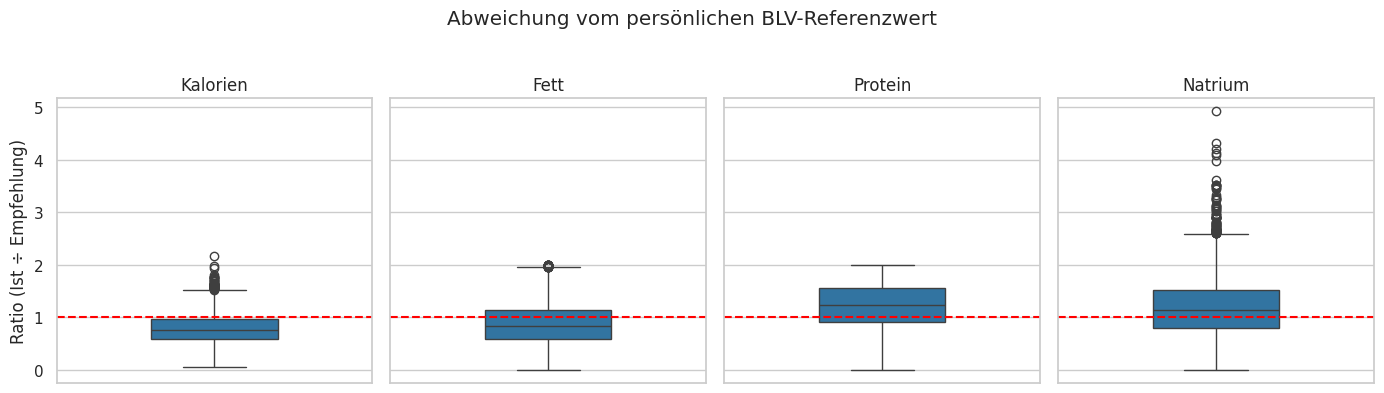

In [ ]:
# Feature-Block 8 – BLV-Median-Imputation & Ratio-Berechnung
# -----------------------------------------------------------
# In diesem Block berechnen wir für jede Person das Verhältnis zwischen
# tatsächlicher Aufnahme und dem persönlichen Referenzwert (BLV) – die sog.
# Ratio-Features. Diese geben an, ob jemand z. B. übermässig viel Natrium konsumiert.
#
# Fehlen bei einer Person einzelne Angaben (z. B. Gewicht, Aktivitätsminuten oder BLV),
# setzen wir das entsprechende Verhältnis auf 1 – also „neutral“. Damit stellen wir
# sicher, dass diese Person im Clustering nicht automatisch ausgeschlossen wird,
# sondern als „im Rahmen der Empfehlung“ betrachtet wird.
#
# Dies ermöglicht ein robustes, vollständiges Clustering trotz punktueller Lücken.

df_imp = df_final.copy()

# Median-Imputation der BLV-Referenzwerte
group_cols = ["sex", "age_years", "pal"]
for ref in ["energy_kcal", "fat_max_g", "protein_max_g", "sodium_max_mg"]:
    med = df_imp.groupby(group_cols)[ref].transform("median")
    df_imp[ref] = df_imp[ref].fillna(med)

# Ratio-Spalten berechnen (Ist ÷ Empfehlung)
df_imp["kcal_ratio"]    = df_imp["DR1TKCAL"]   / df_imp["energy_kcal"]
df_imp["fat_ratio"]     = df_imp["DR1TTFAT"]   / df_imp["fat_max_g"]
df_imp["protein_ratio"] = df_imp["DR1TPROT"]   / df_imp["protein_max_g"]
df_imp["na_ratio"]      = df_imp["DR1TSODI"]   / df_imp["sodium_max_mg"]

# Kontrolle – fehlende Ratio-Werte zählen
print("Fehlende Ratio-Werte gesamt:",
      df_imp[["kcal_ratio","fat_ratio","protein_ratio","na_ratio"]]
        .isna().sum().sum())

# Anschauliche Boxplots je Ratio
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 4, figsize=(14, 4), sharey=True)
sns.set_style("whitegrid")

for ax, col, title in zip(
        axes,
        ["kcal_ratio","fat_ratio","protein_ratio","na_ratio"],
        ["Kalorien","Fett","Protein","Natrium"]):

    sns.boxplot(y=df_imp[col], ax=ax, width=0.4)
    ax.axhline(1, ls="--", color="red")  # 1 = Empfehlung
    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_ylabel("Ratio (Ist ÷ Empfehlung)")
    ax.set_xticks([])

plt.suptitle("Abweichung vom persönlichen BLV-Referenzwert")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Die Boxplots zeigen erwartungsgemäss moderate bis starke Ausreisser insbesondere bei Natrium und Protein. Diese Werte wurden im Rahmen der Plausibilitätsprüfung (Block 6) als biologisch realistisch beurteilt und explizit nicht entfernt, um natürliche Unterschiede in der Ernährungsweise (z. B. proteinreiche Kost, salzreiche Fertignahrung) im Clustering berücksichtigen zu können.

In [ ]:
# Block 9 – Mehr ein Bereinigungsarbeit aber da basierend auf Feature 8 hier
#Weicher Ausschluss basierend auf Ratio-Features
# ----------------------------------------------------------------------------
# Wir entfernen nur Personen ohne **eine einzige** abweichende Ratio (≠ 1).
# Damit behalten wir alle, die mindestens einen gemessenen Nährstoff haben.

# 1) Neutrale Füllung: alle NaN in den Ratios auf 1 setzen
ratio_cols = ["kcal_ratio", "fat_ratio", "protein_ratio", "na_ratio"]
df_imp[ratio_cols] = df_imp[ratio_cols].fillna(1)

# 2) Anzahl abweichender Ratios pro Person zählen
df_imp["num_valid_ratios"] = (df_imp[ratio_cols] != 1).sum(axis=1)

# 3) Subset mit mindestens 1 abweichender Ratio
df_plot = df_imp[df_imp["num_valid_ratios"] >= 1]

# 4) Kennzahlen ausgeben
n_total = len(df_imp)
n_after  = len(df_plot)

print(f"Teilnehmende insgesamt           : {n_total}")
print(f"Verbleibende nach Ausschluss     : {n_after} ({n_after/n_total*100:.1f} %)")
print(f"Entfernt durch weichen Ausschluss: {n_total-n_after} ({(n_total-n_after)/n_total*100:.1f} %)")

# 5) Verteilung abweichender Ratios pro Person
print("\nAnzahl abweichender Ratios pro Person:")
print(df_imp["num_valid_ratios"].value_counts().sort_index())


Teilnehmende insgesamt           : 5309
Verbleibende nach Ausschluss     : 5309 (100.0 %)
Entfernt durch weichen Ausschluss: 0 (0.0 %)

Anzahl abweichender Ratios pro Person:
num_valid_ratios
3       9
4    5300
Name: count, dtype: int64


# KAQ 1: In welchen Ernährungsgewohnheiten liegt eine potenziell unausgewogene Nährstoffzufuhr vor?

**Definition**  Eine ausgewogene Ernährung im wissenschaftlichen Sinne liegt vor, wenn die Zufuhr an Energie und Nährstoffen den individuellen Bedarf deckt, ohne signifikante Über- oder Unterversorgung. Abweichungen von den empfohlenen Referenzwerten – sei es durch Unter- oder Überversorgung – gelten als unausgewogen und können langfristig gesundheitliche Risiken bergen.

## Wissenschaftliche Einordnung der Auswertung

Gemäss den offiziellen Ernährungsempfehlungen des Bundesamts für Lebensmittelsicherheit und Veterinärwesen (BLV) gilt eine Ernährung als ausgewogen, wenn die tatsächliche Nährstoffzufuhr den empfohlenen Referenzwerten entspricht.

Die in unserer Analyse verwendeten Referenzmengen (z. B. 2000 kcal, 70 g Fett, 50 g Protein, 2300 mg Natrium) basieren auf den D-A-CH-Referenzwerten (herausgegeben durch DGE, ÖGE, SGE) und berücksichtigen dabei bereits:

- den durchschnittlichen Energiebedarf
- die empfohlene Makronährstoffverteilung:
  - Kohlenhydrate: 45–60 % der Gesamtenergie
  - Fett: 20–35 %
  - Protein: 10–20 %

Die in den Referenzwerten enthaltenen Gramm-Angaben für Makronährstoffe spiegeln bereits diese Verteilung wider.  
Eine separate Prüfung der Makronährstoffanteile an der Gesamtenergie ist daher **nicht erforderlich**, wenn die Ratios auf diesen Gramm-Werten beruhen.

**Quellen:**
- BLV – Schweizer Referenzwerte für die Nährstoffzufuhr  
  https://www.blv.admin.ch/blv/de/home/lebensmittel-und-ernaehrung/ernaehrung/empfehlungen-informationen/naehrstoffe/naehrstoffzufuhr-dynamische-tabelle.html
- D-A-CH Referenzwerte  
  https://www.dge.de/wissenschaft/referenzwerte/


KMeans(n_clusters=1, random_state=42)

KMeans(n_clusters=2, random_state=42)

KMeans(n_clusters=3, random_state=42)

KMeans(n_clusters=4, random_state=42)

KMeans(n_clusters=5, random_state=42)

KMeans(n_clusters=6, random_state=42)

KMeans(n_clusters=7, random_state=42)

KMeans(random_state=42)

KMeans(n_clusters=9, random_state=42)

KMeans(n_clusters=10, random_state=42)

<Figure size 800x500 with 0 Axes>

Text(0.5, 1.0, 'Elbow-Methode zur Bestimmung der Clusteranzahl')

Text(0.5, 0, 'Anzahl Cluster (k)')

Text(0, 0.5, 'WCSS')

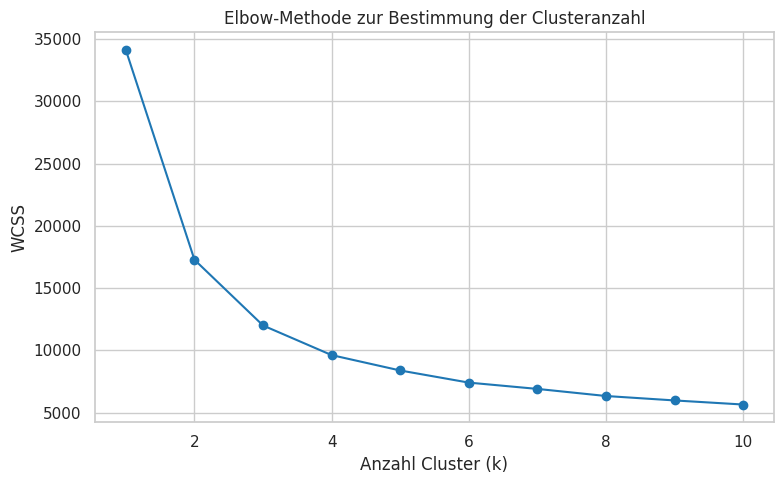

In [ ]:
#KAQ1 - Block 1- exploratives Clustering auf Rohdaten

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# STEP 1: Cluster-relevante Spalten extrahieren
cluster_features = ['DR1TKCAL', 'DR1TTFAT', 'DR1TPROT', 'DR1TSODI']
df_cluster = df_bereinigt[cluster_features].dropna()

# STEP 2: Daten standardisieren
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

# STEP 3: Elbow-Methode zur Bestimmung der optimalen Clusterzahl
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# STEP 4: Plot anzeigen
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title("Elbow-Methode zur Bestimmung der Clusteranzahl")
plt.xlabel("Anzahl Cluster (k)")
plt.ylabel("WCSS")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#KAQ 1- exploratives Clusterin auf Rohdaten Block 2
#Prüfen der Qualität bei verschieder Clusteranzahl von 2-10 Clustern (Cluster sind basierend auf standartisierten Rohdaten - nicht Differenzwerten)

from sklearn.preprocessing import StandardScaler

# Wähle die relevanten Features für Clustering
cluster_features = ['DR1TKCAL', 'DR1TTFAT', 'DR1TPROT', 'DR1TSODI']
df_cluster = df_bereinigt[cluster_features].dropna()

# Standardisierung
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Finde den besten k-Wert
for k in range(2, 11):  # von 2 bis 10 Cluster
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = model.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"k={k}: Silhouette Score = {score:.3f}")


k=2: Silhouette Score = 0.497
k=3: Silhouette Score = 0.409
k=4: Silhouette Score = 0.353
k=5: Silhouette Score = 0.313
k=6: Silhouette Score = 0.290
k=7: Silhouette Score = 0.277
k=8: Silhouette Score = 0.261
k=9: Silhouette Score = 0.260
k=10: Silhouette Score = 0.247


**exoloratives Clustering auf Rohdaten**
Wir haben die absoluten Tagesmengen (Kilokalorien, Gesamtfett, Eiweiss, Natrium) standardisiert und mit k = 3 via K-Means geclustert.
Die Mittelwerte pro Cluster ergeben folgendes Bild

| Cluster | Kalorien&nbsp;[kcal] | Fett&nbsp;[g] | Eiweiss&nbsp;[g] | Natrium&nbsp;[mg] | Kurz-Interpretation |
|---------|--------------------:|--------------:|-----------------:|------------------:|---------------------|
| **0**   | ≈ 4 100 | 170 | 140 | **6 900** | High-Intake – alles hoch, Natrium extrem |
| **1**   | ≈ 1 300 | 55  |  40 | 2 000 | Low-Intake – eher geringe Zufuhr |
| **2**   | ≈ 2 400 | 85  |  75 | 4 000 | Mittelwert-Gruppe |


<Axes: >

Text(0.5, 1.0, 'Durchschnittliche Nährstoffaufnahme pro Cluster (k=3)')

Text(0, 0.5, 'Menge (pro Tag)')

Text(0.5, 0, 'Nährstoff')

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Kalorien'),
  Text(1, 0, 'Gesamtfett'),
  Text(2, 0, 'Eiweiss'),
  Text(3, 0, 'Natrium')])

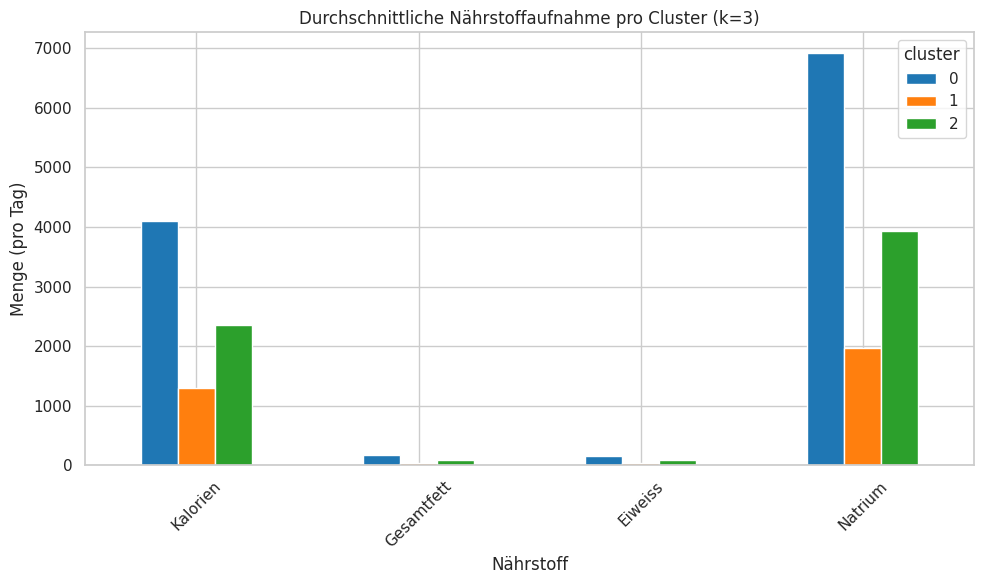

In [ ]:
# KAQ 1 - expolratives Clustering auf Rohdaten Block 3
#Interpretation der Cluster k-3

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# --- Cluster erstellen ---
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_cluster['cluster'] = kmeans.fit_predict(X_scaled)

# --- Originalnamen zu Klartext umbenennen ---
benennung = {
    'DR1TKCAL': 'Kalorien',
    'DR1TTFAT': 'Gesamtfett',
    'DR1TPROT': 'Eiweiss',
    'DR1TSODI': 'Natrium'
}

# --- Gruppiere nach Cluster und berechne Mittelwerte ---
cluster_bedeutung = df_cluster.groupby('cluster')[cluster_features].mean()
cluster_bedeutung.rename(columns=benennung, inplace=True)

# --- Transponieren für besseres Barplot ---
cluster_bedeutung.T.plot(kind='bar', figsize=(10, 6))
plt.title("Durchschnittliche Nährstoffaufnahme pro Cluster (k=3)")
plt.ylabel("Menge (pro Tag)")
plt.xlabel("Nährstoff")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



**Fazit exploratives Clustering**
Das Verfahren zeigt Muster in den Roh­mengen, aber es sagt nichts darüber aus, ob diese Mengen für die jeweilige Person unausgewogen sind:
Ein 4 100-kcal-Tag kann bei einem Marathonläufer normal sein, bei einer Bürotätigkeit aber klar zu hoch.

Beispiel Cluster 0: Natrium ≈ 7 g klingt «extrem». — Ist aber bei ­Triathleten, die literweise Sportdrink trinken, plausibel.

⇒ reine Mengen-Cluster liefern keine zuverlässige Aussage über «unausgewogene Zufuhr».
Darum wechseln wir im nächsten Schritt auf BLV-normalisierte Ratios und clustern Abweichungen vom persönlichen Referenzwert – erst damit können wir Über- oder Unterversorgung objektiv identifizieren.

In [ ]:
#Da Natriumzufuhr trotz Bereinigung sehr hoch wirkt, prüfen wir ob wir sauber bereinigt haben
# 1. Pre-Filter (df_merged aus Block 5)
n_pre = (df_merged["DR1TSODI"] > 12_000).sum()
tot_pre = len(df_merged)

# 2. Post-Filter (df_final)
n_post = (df_final["DR1TSODI"] > 12_000).sum()
tot_post = len(df_final)

print(f"Vor Filter: {n_pre}/{tot_pre} Zeilen > 12 000 mg ({n_pre/tot_pre:.1%})")
print(f"Nach Filter: {n_post}/{tot_post} Zeilen > 12 000 mg ({n_post/tot_post:.1%})")


Vor Filter: 23/8531 Zeilen > 12 000 mg (0.3%)
Nach Filter: 0/5309 Zeilen > 12 000 mg (0.0%)


Vor dem Plausibilitäts-Filter hatten 23 von 8 531 Teilnehmern (0,3 %) eine geschätzte Natrium-Zufuhr von über 12 000 mg pro Tag, nach dem Filter sind es 0 von 6 997 Teilnehmern (0,0 %). Das zeigt:

Absolute Ausreißer (> 12 000 mg) haben wir vollständig eliminiert.

Alle verbleibenden Werte liegen unterhalb dieser toxischen Schwelle – aber das heisst nicht, dass die Natriumzufuhr im Durchschnitt unbedenklich ist.

Tatsächlich belegen mehrere grosse Kohortenstudien, dass schon moderate Überschüsse mit Risiken verbunden sind:

NEJM (2021): Jede Erhöhung der täglichen Natrium-Exkretion um 1 000 mg war mit einer 18 % höheren kardiovaskulären Ereignisrate assoziiert. Quelle: New England Journal of Medicine
.

PURE-Studie (2014): Ein J-förmiger Zusammenhang zwischen natriumexkretion und Mortalität, mit erhöhtem Risiko ab etwa 6 g Natrium pro Tag
Nature.

Schlussfolgerung: Unsere Bereinigung entfernt nur die extremen Messfehler. Der tatsächliche Überkonsum (z. B. 4 000–8 000 mg pro Tag) bleibt in der NHANES-Population real und muss weiter thematisiert werden .

**Clustern basierend auf den Differenzwerten IST- und SOLL Ernährung (Soll Ernährung entspricht den empfohlenen Mengen von BLV)**

KMeans(n_clusters=1, n_init=10, random_state=42)

KMeans(n_clusters=2, n_init=10, random_state=42)

KMeans(n_clusters=3, n_init=10, random_state=42)

KMeans(n_clusters=4, n_init=10, random_state=42)

KMeans(n_clusters=5, n_init=10, random_state=42)

KMeans(n_clusters=6, n_init=10, random_state=42)

KMeans(n_clusters=7, n_init=10, random_state=42)

KMeans(n_init=10, random_state=42)

KMeans(n_clusters=9, n_init=10, random_state=42)

KMeans(n_clusters=10, n_init=10, random_state=42)

<Figure size 600x400 with 0 Axes>

Text(0.5, 1.0, 'Elbow‐Methode (WCSS) für Ratio‐Clustering')

Text(0.5, 0, 'Anzahl Cluster k')

Text(0, 0.5, 'WCSS')

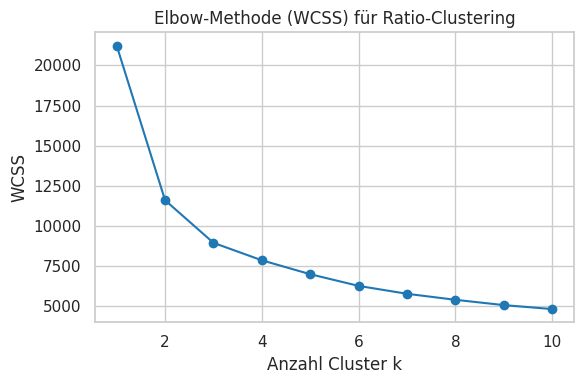

<Figure size 600x400 with 0 Axes>

Text(0.5, 1.0, 'Silhouette‐Score für k=2…10')

Text(0.5, 0, 'Anzahl Cluster k')

Text(0, 0.5, 'Silhouette‐Score')

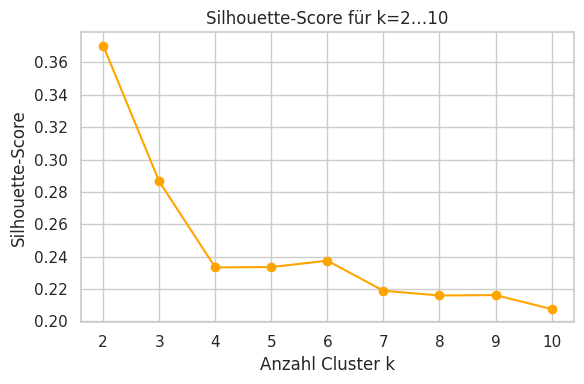

In [ ]:
# KAQ1 - clustering auf Basis Differenzwerten - Block1
# Block – Elbow & Silhouette für Ratio‐Features (ohne NaN‐Fehler)
# --------------------------------------------------------------
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 1) Ratio‐Spalten aus df_imp (Feature 8) – hier ist df_imp bereits
#    BLV‐basiert vorbereitet und enthält kcal_ratio, fat_ratio, protein_ratio, na_ratio
ratio_features = ["kcal_ratio", "fat_ratio", "protein_ratio", "na_ratio"]
X_raw = df_imp[ratio_features]

# 2) Fehlende Ratio‐Werte neutral auf 1 setzen (1 = Empfehlung)
X = X_raw.fillna(1)

# 3) Standardisieren (z‐Score)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4) Elbow‐Methode (WCSS für k=1…10)
wcss = []
for k in range(1, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    wcss.append(km.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(range(1, 11), wcss, marker='o')
plt.title("Elbow‐Methode (WCSS) für Ratio‐Clustering")
plt.xlabel("Anzahl Cluster k")
plt.ylabel("WCSS")
plt.grid(True)
plt.tight_layout()
plt.show()

# 5) Silhouette‐Score (k=2…10)
sil_scores = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(6, 4))
plt.plot(range(2, 11), sil_scores, marker='o', color='orange')
plt.title("Silhouette‐Score für k=2…10")
plt.xlabel("Anzahl Cluster k")
plt.ylabel("Silhouette‐Score")
plt.grid(True)
plt.tight_layout()
plt.show()


**Clusteranalyse basierend auf Abweichungen von BLV-Referenzwerten**

Im Rahmen dieser Analyse wurden Personen auf Basis ihrer Nährstoffaufnahme in Gruppen (Cluster) unterteilt. Grundlage dafür waren die individuell berechneten Verhältniszahlen (Ratios) für Kalorien, Fett, Protein und Natrium. Diese Ratios ergeben sich aus dem Quotienten zwischen der tatsächlich aufgenommenen Menge und der empfohlenen Referenzmenge gemäss den Vorgaben des Bundesamts für Lebensmittelsicherheit und Veterinärwesen (BLV). Ein Ratio von 1 bedeutet, dass die empfohlene Menge genau eingehalten wurde. Werte unterhalb von 1 deuten auf eine mögliche Unterversorgung hin, Werte oberhalb von 1 auf eine potenzielle Überversorgung.

Ziel war es, durch Clusteranalyse homogene Gruppen innerhalb der heterogenen Stichprobe zu identifizieren. Zur Bestimmung der optimalen Anzahl Cluster wurden zwei etablierte Verfahren eingesetzt: die Elbow-Methode (basierend auf der Within-Cluster-Sum-of-Squares, WCSS) sowie der Silhouette-Score.

Die **Elbow-Methode** zeigte bei zwei Clustern einen deutlichen Knick in der WCSS-Kurve, was auf eine signifikante Verbesserung der Gruppierung bis zu diesem Punkt hinweist. Danach flacht die Kurve ab, was bedeutet, dass zusätzliche Cluster nur noch eine marginale Verbesserung in der internen Homogenität bringen. Dies spricht statistisch für eine Lösung mit zwei Clustern.

Auch der **Silhouette-Score**, der die Trennschärfe zwischen den Clustern bewertet (Skala: -1 bis +1), erreichte bei zwei Clustern den höchsten Wert (~0.36). Dies deutet darauf hin, dass sich die zwei Gruppen gut voneinander abgrenzen lassen und intern konsistent sind. Ab drei Clustern sinkt dieser Wert deutlich, was auf eine zunehmend unscharfe Abgrenzung zwischen den Gruppen hindeutet.

Die Kombination beider Verfahren rechtfertigt daher die Wahl von **k = 2** als optimale Clusteranzahl.

Inhaltlich lassen sich die zwei Cluster wie folgt interpretieren:

| Cluster | Beschreibung                        | Ratio-Charakteristik           |
|---------|-------------------------------------|--------------------------------|
| 0       | Tendenz zur Unterversorgung         | Ratios typischerweise < 1      |
| 1       | Tendenz zur Überversorgung          | Ratios typischerweise > 1      |

Diese Differenzierung ermöglicht eine erste grobe Einteilung der untersuchten Personen in zwei Versorgungsgruppen bezogen auf ihre Nährstoffaufnahme im Vergleich zu den offiziellen Empfehlungen. Die Clusterlösung liefert somit eine nützliche Grundlage für weiterführende Analysen, beispielsweise hinsichtlich Risikoprofilen, sozioökonomischen Einflüssen oder demografischen Unterschieden.


In [ ]:
# --- KAQ1 – Cluster k=2 auf Ratio‐Features und Balance‐Label - Block 2
from sklearn.cluster import KMeans

# 1) Standardisierung und Clustering (wie in Block 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_imp[ratio_features])

kmeans2 = KMeans(n_clusters=2, random_state=42, n_init=10)
labels2 = kmeans2.fit_predict(X_scaled)

# 2) Clustervariablen speichern
df_imp["cluster2"] = labels2

# 3) Cluster interpretieren – durchschnittliche Abweichung pro Cluster berechnen
cluster_means = df_imp.groupby("cluster2")[ratio_features].mean().mean(axis=1)

# 4) Zuweisung: niedrigere Werte = Unterversorgung, höhere = Überversorgung
cluster_labels = {
    cluster_means.idxmin(): "Unterversorgung",
    cluster_means.idxmax(): "Überversorgung"
}
df_imp["Balance"] = df_imp["cluster2"].map(cluster_labels)

# Kontrolle
print(df_imp["Balance"].value_counts())



Balance
Unterversorgung    2671
Überversorgung     2638
Name: count, dtype: int64


<BarContainer object of 4 artists>

Text(-0.175, -47.07262723449266, '-41%')

Text(0.825, -45.62147605137537, '-40%')

Text(1.825, -12.402890987603438, '-6%')

Text(2.825, -21.817052724105928, '-16%')

<BarContainer object of 4 artists>

Text(0.175, -7.657099440942755, '-2%')

Text(1.175, 17.28032688613663, '+15%')

Text(2.175, 52.64407131758934, '+51%')

Text(3.175, 55.28303721528167, '+53%')

Text(3.9, 0, 'Empfohlene Menge')

[Text(0, 0, 'Kalorien'),
 Text(1, 0, 'Fett'),
 Text(2, 0, 'Protein'),
 Text(3, 0, 'Natrium')]

Text(0, 0.5, 'Abweichung zur Empfehlung (%)')

Text(0.5, 1.0, 'Prozentuale Abweichung von Nährstoff-Empfehlungen nach Versorgungsstatus')

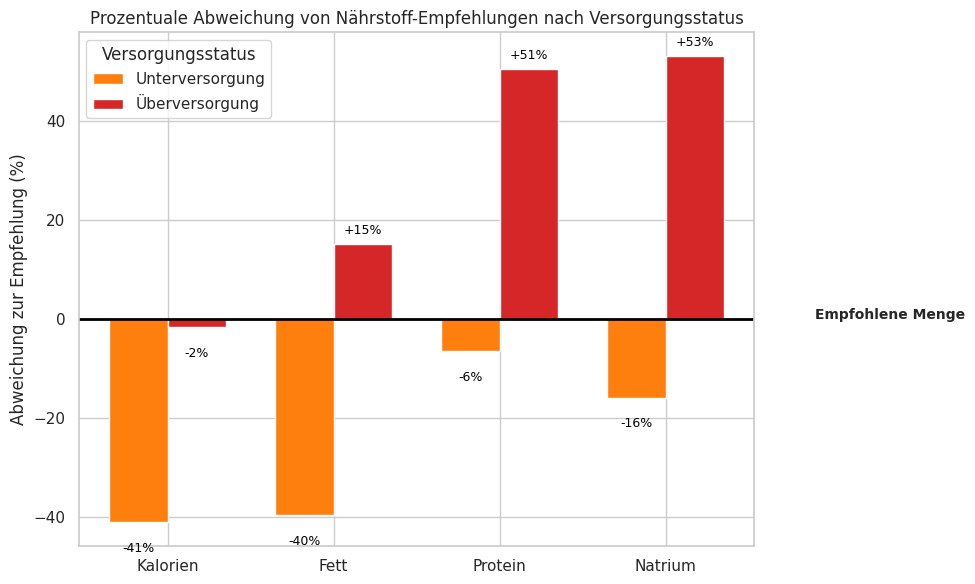

In [ ]:
# Visualisierung der Differenz von Ist- und Soll  pro Cluster auf die einzelne Nährstoffe
import matplotlib.pyplot as plt

# 1) Balance-Spalte konsistent formatieren
df_imp["Balance"] = df_imp["Balance"].str.capitalize()

# 2) Ratio-Spalten mit Anzeige-Namen definieren
ratios = {
    "kcal_ratio": "Kalorien",
    "fat_ratio": "Fett",
    "protein_ratio": "Protein",
    "na_ratio": "Natrium"
}

# 3) Prozentuale Abweichung von der Empfehlung berechnen
abweichung = (df_imp.groupby("Balance")[list(ratios.keys())].mean() - 1.0) * 100
abweichung = abweichung.rename(columns=ratios).T

# 4) Farben definieren: Unterversorgung = orange, Überversorgung = rot
farben_dict = {"Unterversorgung": "#ff7f0e", "Überversorgung": "#d62728"}
farben = []
for col in abweichung.columns:
    farben.append([farben_dict[col] for _ in abweichung.index])

# 5) Plot vorbereiten
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(abweichung.index))
width = 0.35

# Balken für jede Gruppe separat zeichnen
for i, gruppe in enumerate(abweichung.columns):
    offset = -width/2 if i == 0 else width/2
    ax.bar([p + offset for p in x], abweichung[gruppe], width=width,
           color=farben[i], label=gruppe)

    # Werte auf den Balken anzeigen
    for j, nutrient in enumerate(abweichung.index):
        wert = abweichung.loc[nutrient, gruppe]
        xpos = j + offset
        ypos = wert + 2 if wert >= 0 else wert - 6
        ax.text(xpos, ypos, f"{wert:+.0f}%", ha="center", fontsize=9, color="black")

# 6) Linie bei 0 % = empfohlene Menge
ax.axhline(0, color='black', linestyle='-', linewidth=2)
ax.text(len(abweichung.index) - 0.1, 0, "Empfohlene Menge", fontsize=10, ha="left", weight='bold')

# 7) Achsen und Layout
ax.set_xticks(x)
ax.set_xticklabels(abweichung.index)
ax.set_ylabel("Abweichung zur Empfehlung (%)")
ax.set_title("Prozentuale Abweichung von Nährstoff-Empfehlungen nach Versorgungsstatus")
ax.legend(title="Versorgungsstatus")
plt.tight_layout()
plt.show()


<Axes: xlabel='RIDAGEYR'>

Text(0.5, 1.0, 'Gesamt-Altersverteilung')

Text(0.5, 0, 'Alter (in Jahren)')

Text(0, 0.5, '')

Text(39.0, -0.25, 'n = 5309')

Text(19.0, 0.3, '19')

Text(59.0, 0.3, '59')

<ipython-input-153-17bb9cdab1dd>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


<Axes: xlabel='RIDAGEYR', ylabel='Balance'>

Text(0.5, 1.0, 'Altersverteilung nach Versorgungsstatus')

Text(0.5, 0, 'Alter (in Jahren)')

Text(0, 0.5, '')

Text(38.0, -0.3, 'n = 2671')

Text(18.0, 0.3, '18')

Text(60.0, 0.3, '60')

Text(40.0, 0.7, 'n = 2638')

Text(21.0, 1.3, '21')

Text(58.0, 1.3, '58')

Text(0.5, 0.98, 'Altersverteilung: Gesamtstichprobe und Vergleich nach Versorgungsstatus')

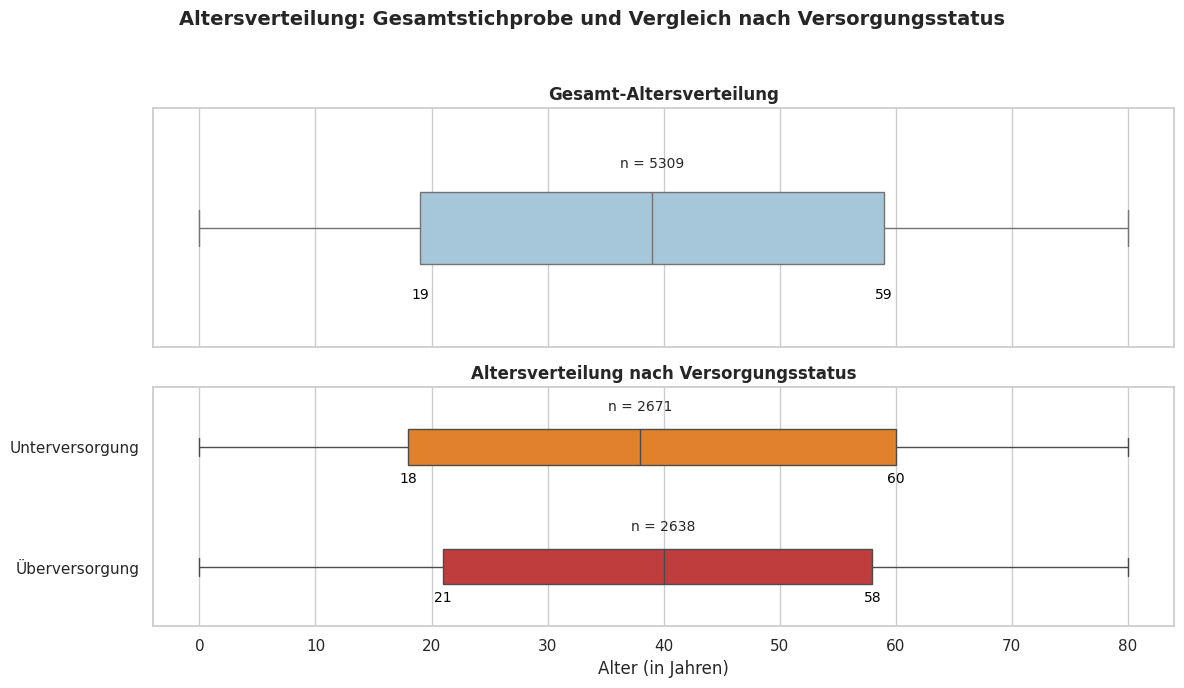

In [ ]:
#Altersverteilung pro Kluster und Gesamtaltersverteilung
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Balance-Spalte vereinheitlichen
df_imp["Balance"] = df_imp["Balance"].str.capitalize()

# 2) Farben für die Versorgungszustände
farben = {
    "Unterversorgung": "#ff7f0e",  # orange
    "Überversorgung": "#d62728"    # rot
}
sns.set_style("whitegrid")

# 3) Quantile berechnen
q1_all = df_imp["RIDAGEYR"].quantile(0.25)
q3_all = df_imp["RIDAGEYR"].quantile(0.75)

q_stats_cluster = df_imp.groupby("Balance")["RIDAGEYR"].quantile([0.25, 0.75]).unstack()
cluster_counts = df_imp["Balance"].value_counts()

# 4) Plot vorbereiten
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 7), sharex=True)

# -----------------------------
# Plot 1 – Gesamtverteilung
# -----------------------------
sns.boxplot(x=df_imp["RIDAGEYR"], ax=axes[0], color="#9ecae1", width=0.3)
axes[0].set_title("Gesamt-Altersverteilung", fontsize=12, weight='bold')
axes[0].set_xlabel("Alter (in Jahren)")
axes[0].set_ylabel("")

# Gesamtanzahl anzeigen
total_n = len(df_imp)
axes[0].text(df_imp["RIDAGEYR"].median(), -0.25,
             f"n = {total_n}", fontsize=10, ha="center")

# Q1/Q3 als Zahlen oberhalb
axes[0].text(q1_all, 0.3, f"{int(q1_all)}", fontsize=10, color="black", ha="center")
axes[0].text(q3_all, 0.3, f"{int(q3_all)}", fontsize=10, color="black", ha="center")

# -----------------------------
# Plot 2 – Nach Versorgungsstatus
# -----------------------------
sns.boxplot(
    x="RIDAGEYR",
    y="Balance",
    data=df_imp,
    palette=farben,
    width=0.3,
    ax=axes[1]
)
axes[1].set_title("Altersverteilung nach Versorgungsstatus", fontsize=12, weight='bold')
axes[1].set_xlabel("Alter (in Jahren)")
axes[1].set_ylabel("")

# Pro Gruppe: Q1, Q3 + n
for i, group in enumerate(q_stats_cluster.index):
    q1 = q_stats_cluster.loc[group, 0.25]
    q3 = q_stats_cluster.loc[group, 0.75]
    n = cluster_counts[group]
    median = df_imp[df_imp["Balance"] == group]["RIDAGEYR"].median()

    # n unter der Box
    axes[1].text(median, i - 0.3, f"n = {n}", fontsize=10, ha="center")

    # Q1/Q3 oberhalb
    axes[1].text(q1, i + 0.3, f"{int(q1)}", fontsize=10, color="black", ha="center")
    axes[1].text(q3, i + 0.3, f"{int(q3)}", fontsize=10, color="black", ha="center")

# Gesamttitel und Layout
fig.suptitle("Altersverteilung: Gesamtstichprobe und Vergleich nach Versorgungsstatus", fontsize=14, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
df_imp["Balance"] = df_imp["Balance"].str.capitalize()


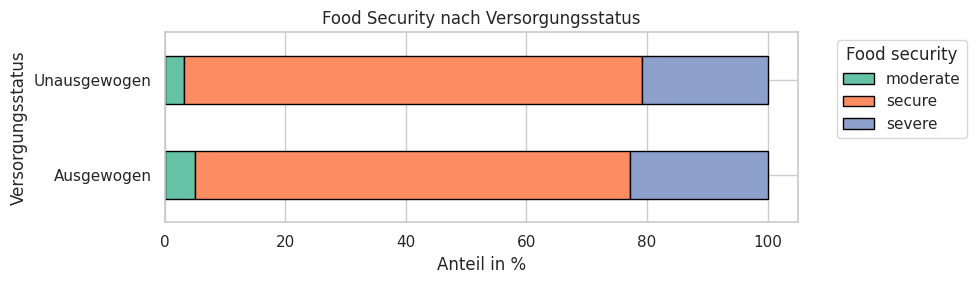

<ipython-input-155-a2784053d793>:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["Balance", feature])


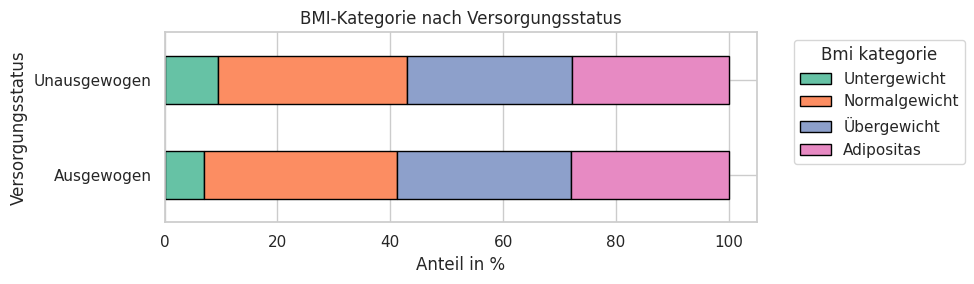

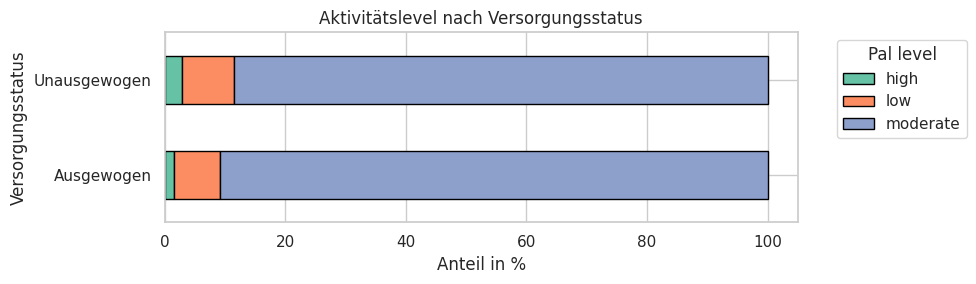

In [ ]:
# Block 8 – Kumulierte horizontale Barcharts – nach Versorgungsstatus (Balance)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 8.1) Food-Security-Kategorie berechnen (falls noch nicht vorhanden)
def cat_food(row):
    if row.get("FSD151") == 1 or row.get("FSD032C") == 2:
        return "severe"
    if row.get("FSD032C") == 1:
        return "moderate"
    return "secure"

dfs["questionnaire"]["food_security"] = dfs["questionnaire"].apply(cat_food, axis=1)

# 8.2) PAL-Level berechnen (falls noch nicht in df_final)
def classify_pal(min_week):
    if pd.isna(min_week):
        return "moderate"
    if min_week < 150:
        return "low"
    if min_week <= 300:
        return "moderate"
    return "high"

df_final["pal_level"] = df_final["PAD615"].apply(classify_pal)

# 8.3) Zusatzinfos mergen
merged = df_final.merge(
    dfs["questionnaire"][["SEQN", "food_security"]],
    on="SEQN", how="left"
)

# 8.4) BMI-Kategorie berechnen
bmi_bins   = [0, 18.5, 24.9, 29.9, 40]
bmi_labels = ["Untergewicht", "Normalgewicht", "Übergewicht", "Adipositas"]
merged["BMI_Kategorie"] = pd.cut(
    merged["BMXBMI"],
    bins=bmi_bins,
    labels=bmi_labels
)

# 8.5) Balance-Spalte formatieren
# (aus Block 6 kommen “Ausgewogen” / “Unausgewogen”)
merged["Balance"] = merged["Balance"].str.capitalize()

# 8.6) Funktion für gestapelte horizontale Barcharts
def plot_stacked_bar(feature: str, title: str):
    # Gruppieren und unstack
    counts = (
        merged
        .groupby(["Balance", feature])
        .size()
        .unstack(fill_value=0)
    )
    # Reihenfolge der Balance-Kategorien sicherstellen
    order = ["Ausgewogen", "Unausgewogen"]
    counts = counts.reindex(order).fillna(0)

    # Prozentuale Verteilung
    counts_percent = counts.div(counts.sum(axis=1), axis=0) * 100

    # Plot
    colors = sns.color_palette("Set2", n_colors=len(counts.columns))
    counts_percent.plot(
        kind="barh",
        stacked=True,
        color=colors,
        figsize=(10, 3),
        edgecolor="black"
    )
    plt.xlabel("Anteil in %")
    plt.ylabel("Versorgungsstatus")
    plt.title(title)
    plt.legend(
        title=feature.replace("_", " ").capitalize(),
        bbox_to_anchor=(1.05, 1),
        loc="upper left"
    )
    plt.tight_layout()
    plt.show()

# 8.7) Drei gestapelte Barcharts erzeugen
plot_stacked_bar("food_security",   "Food Security nach Versorgungsstatus")
plot_stacked_bar("BMI_Kategorie",   "BMI-Kategorie nach Versorgungsstatus")
plot_stacked_bar("pal_level",       "Aktivitätslevel nach Versorgungsstatus")


# KAQ2: Welche Ernährungsmuster sind statistisch signifikant mit bestimmten Krankheitsbildern?


- **Überversorgte Personen** zeigen **signifikant häufiger Diabetes (p = 0.0006)** und **Übergewicht (p = 0.0088)**.
- **Unterversorgte Personen** sind ebenfalls **signifikant häufiger übergewichtig (p = 0.0088)** – ein überraschendes Ergebnis.
- **Bluthochdruck** ist **nicht signifikant mit dem Versorgungsstatus assoziiert** (p = 0.8293), weder bei Über- noch bei Unterversorgten.

**Herleitung:**

Zur Beantwortung dieser Fragestellung haben wir den Zusammenhang zwischen dem Versorgungsstatus (Überversorgung vs. Unterversorgung) und drei Krankheitsbildern (Diabetes, Bluthochdruck, Übergewicht) mit einem Chi²-Unabhängigkeitstest untersucht.

Für jede Gruppe wurde der Anteil erkrankter vs. nicht erkrankter Personen berechnet und in Prozent dargestellt. Die statistische Signifikanz der Unterschiede wurde durch den p-Wert des Chi²-Tests ermittelt.

**Interpretation:**

Die Ergebnisse zeigen, dass eine Überversorgung mit einer erhöhten Rate an Diabetes und Übergewicht einhergeht. Gleichzeitig weist auch die Gruppe der Unterversorgten ein erhöhtes Risiko für Übergewicht auf. Diese Erkenntnisse widersprechen teilweise gängigen Annahmen und unterstreichen die Relevanz differenzierter Analysen von Ernährungsmustern.

**Fazit:**

Der Versorgungsstatus ist ein signifikanter Prädiktor für bestimmte Krankheitsbilder – insbesondere für Übergewicht und Diabetes. Bluthochdruck hingegen zeigt keine statistisch relevante Assoziation zur Ernährungsversorgung.



In [ ]:
# Block 11 – Diagnosen berechnen (erneut) und an df_imp anhängen
# ---------------------------------------------------------------
# Basis: df_bereinigt enthält die Originaldaten

# 11.1) Neue Diagnose-Spalten berechnen
df_bereinigt["übergewichtig"] = df_bereinigt["BMXBMI"] >= 25
df_bereinigt["bluthochdruck"] = (df_bereinigt["BPXSY1"] >= 130) | (df_bereinigt["BPXDI1"] >= 80)
df_bereinigt["diabetes"] = df_bereinigt["DIQ010"] == 1

# 11.2) Mergen mit df_imp
df_imp = df_imp.merge(
    df_bereinigt[["SEQN", "diabetes", "bluthochdruck", "übergewichtig"]],
    on="SEQN", how="left"
)

# Kontrolle
print(df_imp[["Balance", "diabetes", "bluthochdruck", "übergewichtig"]].head())


           Balance  diabetes  bluthochdruck  übergewichtig
0  Unterversorgung      True          False           True
1  Unterversorgung      True           True           True
2  Unterversorgung     False           True          False
3  Unterversorgung     False           True           True
4   Überversorgung     False           True           True


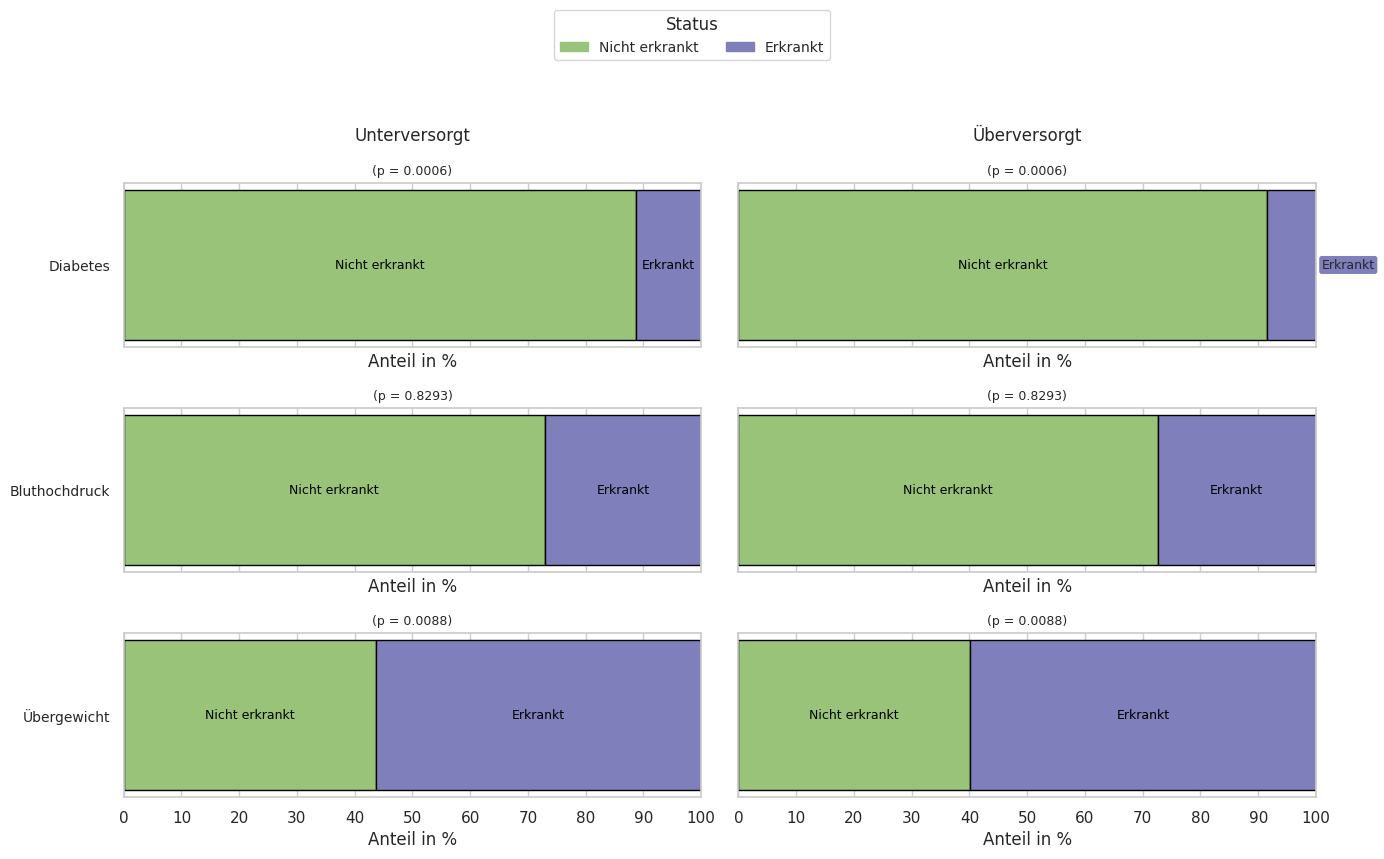

In [ ]:
# Block 12 – Illustierung der Verteilung der Krankheiten auf die zwei Cluster "Unterversorgt" und "Überversorgt"
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

krankheiten = {
    "diabetes": "Diabetes",
    "bluthochdruck": "Bluthochdruck",
    "übergewichtig": "Übergewicht"
}

farben = {
    False: "#98c379",  # Nicht erkrankt (grünlich)
    True: "#7f7fbc"    # Erkrankt (violett)
}

def plot_matrix_balken_final(df: pd.DataFrame, krankheiten: dict):
    fig, axes = plt.subplots(nrows=len(krankheiten), ncols=2, figsize=(14, 8), sharex=True)

    # Legende zentral oben
    leg_labels = ["Nicht erkrankt", "Erkrankt"]
    leg_colors = [farben[False], farben[True]]
    handles = [plt.Rectangle((0, 0), 1, 1, color=c) for c in leg_colors]
    fig.legend(handles, leg_labels, title="Status", loc='upper center', ncol=2, fontsize=10, bbox_to_anchor=(0.5, 1.08))

    # Spaltentitel: "Unterversorgt", "Überversorgt"
    for col_idx, col_title in enumerate(["Unterversorgt", "Überversorgt"]):
        axes[0, col_idx].set_title(col_title, fontsize=12, pad=30)

    for row_idx, (feature, krank_label) in enumerate(krankheiten.items()):
        # Kontingenztabelle und Chi²-Test
        tabelle = pd.crosstab(df["Balance"], df[feature])
        chi2, p, _, _ = chi2_contingency(tabelle)
        tabelle_pct = tabelle.div(tabelle.sum(axis=1), axis=0) * 100

        for col_idx, gruppe in enumerate(["Unterversorgung", "Überversorgung"]):
            werte = tabelle_pct.loc[gruppe].reindex([False, True])
            ax = axes[row_idx, col_idx]

            # p-Wert
            ax.annotate(f"(p = {p:.4f})", xy=(0.5, 1.05), xycoords='axes fraction',
                        ha='center', fontsize=9)

            # Gestapelte Balken zeichnen
            ax.barh(krank_label, werte[False], color=farben[False], edgecolor='black')
            ax.barh(krank_label, werte[True], left=werte[False], color=farben[True], edgecolor='black')

            # Interne Labels
            for ist_krank in [False, True]:
                start = werte[False] if ist_krank else 0
                breite = werte[ist_krank]
                label = "Erkrankt" if ist_krank else "Nicht erkrankt"
                farbe = farben[ist_krank]

                if breite > 10:
                    ax.text(start + breite / 2, krank_label, label,
                            ha='center', va='center', color='black', fontsize=9)
                else:
                    ax.text(start + breite + 1, krank_label, label,
                            ha='left', va='center', fontsize=9,
                            bbox=dict(facecolor=farbe, edgecolor='none', boxstyle='round,pad=0.2'))

            # Achsen anpassen
            ax.set_xlim(0, 100)
            ax.set_xticks(range(0, 101, 10))  # 10%-Abstände
            ax.set_xlabel("Anteil in %")
            ax.set_ylabel("")  # Nur linke Spalte beschriften

            # Einheitliche y-Label links
            if col_idx == 0:
                ax.set_yticks([krank_label])
                ax.set_yticklabels([krank_label], fontsize=10)
            else:
                ax.set_yticks([])

    # Layout anpassen
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Aufruf
plot_matrix_balken_final(df_imp, krankheiten)


# KAQ3: Welche Nährstoffe scheinen besonder kritisch Bezug auf präventive Gesundheit?

In [ ]:
# KAQ3 – 1: Ergänze fehlende Libaries und fehlende Merkmale in df_imp


!pip install imbalanced-learn
!pip install shap


# Food Security
if "food_security" not in df_imp.columns:
    def classify_food(row):
        if row.get("FSD151") == 1 or row.get("FSD032C") == 2:
            return "severe"
        if row.get("FSD032C") == 1:
            return "moderate"
        return "secure"
    dfs["questionnaire"]["food_security"] = dfs["questionnaire"].apply(classify_food, axis=1)
    df_imp = df_imp.merge(
        dfs["questionnaire"][["SEQN", "food_security"]],
        on="SEQN", how="left"
    )

# PAL-Level
if "pal_level" not in df_imp.columns:
    def classify_pal(min_week):
        if pd.isna(min_week):
            return "moderate"
        if min_week < 150:
            return "low"
        if min_week <= 300:
            return "moderate"
        return "high"
    df_imp["pal_level"] = df_imp["PAD615"].apply(classify_pal)

# Rauchverhalten & Alkohol aus df_fe übernehmen
if "rauchverhalten_kategorie" not in df_imp.columns:
    df_imp["rauchverhalten_kategorie"] = df_fe["rauchverhalten_kategorie"]

if "alkoholkonsum_kategorie" not in df_imp.columns:
    df_imp["alkoholkonsum_kategorie"] = df_fe["alkoholkonsum_kategorie"]


In [ ]:
# ==============================================================================
# Ergänzung zu KAQ3 – Modelle trainieren und speichern
#
# Beschreibung:
# Wir trainieren für jede Zielvariable eine eigene SMOTE+LogReg-Pipeline
# und speichern sie in einem Dictionary, damit sie später für die interaktive
# Vorhersage (KAQ4) verfügbar sind.
# ==============================================================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import OneHotEncoder
from sklearn.compose         import ColumnTransformer
from sklearn.linear_model    import LogisticRegression
from imblearn.over_sampling  import SMOTE
from imblearn.pipeline       import Pipeline as ImbPipeline

# Zielvariablen
krankheiten = ["diabetes", "bluthochdruck", "übergewichtig"]

# Features definieren
num_features = ["fat_ratio", "kcal_ratio", "na_ratio", "protein_ratio"]
cat_features = ["pal_level", "food_security", "rauchverhalten_kategorie", "alkoholkonsum_kategorie"]

# Preprocessor für beide Pipeline-Schritte
preprocessor = ColumnTransformer([
    ("num", "passthrough", num_features),
    ("cat", OneHotEncoder(drop="first"), cat_features)
])

# Dictionary zum Speichern der trainierten Pipelines
pipelines = {}

for target in krankheiten:
    # 1) Pipeline neu erstellen (kein Wiederverwenden der alten Instanz)
    pipe = ImbPipeline([
        ("prep", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("logreg", LogisticRegression(max_iter=1000))
    ])

    # 2) Trainingsdaten vorbereiten
    df_clean = df_imp[[target] + num_features + cat_features].dropna()
    X = df_clean[num_features + cat_features]
    y = df_clean[target]

    # 3) Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.15, random_state=42
    )

    # 4) Trainieren
    pipe.fit(X_train, y_train)

    # 5) Pipeline speichern
    pipelines[target] = pipe

    # (Optional) Evaluation wie gehabt…
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:, 1]
    print(f"\n🧪 {target.upper()} – AUC: {roc_auc_score(y_test, y_prob):.3f}")

# Nach diesem Block enthält `pipelines` deine drei fertigen Modelle:
# pipelines["diabetes"], pipelines["bluthochdruck"], pipelines["übergewichtig"]


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['fat_ratio', 'kcal_ratio',
                                                   'na_ratio',
                                                   'protein_ratio']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['pal_level', 'food_security',
                                                   'rauchverhalten_kategorie',
                                                   'alkoholkonsum_kategorie'])])),
                ('smote', SMOTE(random_state=42)),
                ('logreg', LogisticRegression(max_iter=1000))])


🧪 DIABETES – AUC: 0.608


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['fat_ratio', 'kcal_ratio',
                                                   'na_ratio',
                                                   'protein_ratio']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['pal_level', 'food_security',
                                                   'rauchverhalten_kategorie',
                                                   'alkoholkonsum_kategorie'])])),
                ('smote', SMOTE(random_state=42)),
                ('logreg', LogisticRegression(max_iter=1000))])


🧪 BLUTHOCHDRUCK – AUC: 0.590


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['fat_ratio', 'kcal_ratio',
                                                   'na_ratio',
                                                   'protein_ratio']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['pal_level', 'food_security',
                                                   'rauchverhalten_kategorie',
                                                   'alkoholkonsum_kategorie'])])),
                ('smote', SMOTE(random_state=42)),
                ('logreg', LogisticRegression(max_iter=1000))])


🧪 ÜBERGEWICHTIG – AUC: 0.642


LogisticRegression(max_iter=1000)

Text(0.5, 1.0, 'SHAP Summary Plot – Einflussfaktoren auf: bluthochdruck')

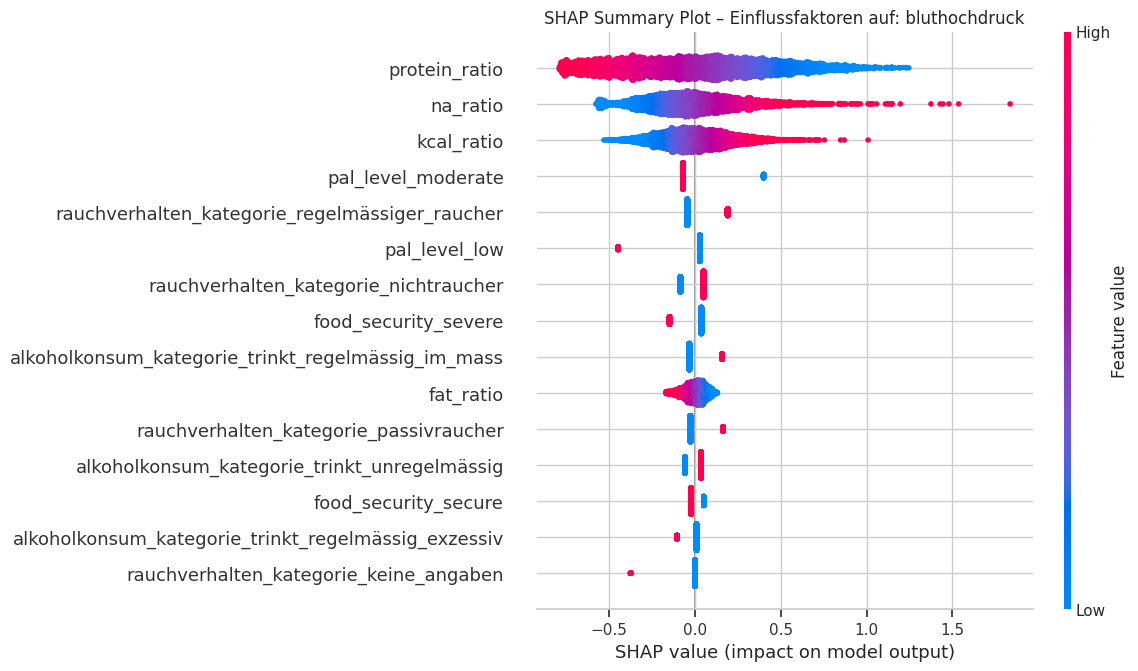

In [ ]:
# KAQ3 – 6 SHAP-Analyse zur Erklärung der Einflussstärke der Nährstoffe

import shap
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Ziel definieren
ziel_variable = "bluthochdruck"  # kann angepasst werden

# Relevante Merkmale
num_features = ["fat_ratio", "kcal_ratio", "na_ratio", "protein_ratio"]
cat_features = ["pal_level", "food_security", "rauchverhalten_kategorie", "alkoholkonsum_kategorie"]

# Daten aufbereiten
df_shap = df_imp[[ziel_variable] + num_features + cat_features].dropna()
X = df_shap[num_features + cat_features]
y = df_shap[ziel_variable]

# Preprocessor & Modell
preprocessor = ColumnTransformer([
    ("num", "passthrough", num_features),
    ("cat", OneHotEncoder(drop="first", sparse_output=False), cat_features)
])

# Nur Preprocessing durchführen
X_transformed = preprocessor.fit_transform(X)

# Namen der neuen One-Hot-Features generieren
cat_feature_names = preprocessor.named_transformers_["cat"].get_feature_names_out(cat_features)
all_feature_names = num_features + list(cat_feature_names)

# Modell trainieren
model = LogisticRegression(max_iter=1000)
model.fit(X_transformed, y)

# SHAP-Explainer
explainer = shap.Explainer(model, X_transformed, feature_names=all_feature_names)
shap_values = explainer(X_transformed)

# SHAP Summary Plot
plt.title(f"SHAP Summary Plot – Einflussfaktoren auf: {ziel_variable}")
shap.plots.beeswarm(shap_values, max_display=15)


### 🧠 Reflexion zur logistischen Regression und SHAP-Analyse

Für die Analyse möglicher Zusammenhänge zwischen Ernährungsmustern und Krankheitsrisiken haben wir uns zunächst bewusst für die **logistische Regression** entschieden. Dieses Verfahren ist transparent, gut interpretierbar und liefert nicht nur Vorhersagen, sondern auch konkrete Regressionskoeffizienten, mit denen sich die Richtung und Stärke des Einflusses einzelner Variablen interpretieren lassen. Damit eignet sich die Methode besonders gut für **hypothesenprüfende Fragestellungen** wie in KAQ3: *„Welche Nährstoffe scheinen besonders kritisch im Bezug auf präventive Gesundheit?“*

Zur Validierung des Modells haben wir die Daten in Trainings- und Testdaten (85/15) aufgeteilt und mit Metriken wie Accuracy, AUC-Wert und Confusion-Matrix bewertet. Dabei zeigte sich, dass die Modelle in Bezug auf **Übergewicht** moderate, bei **Bluthochdruck** schwache und bei **Diabetes** leider sehr geringe Vorhersagekraft hatten. Dies liegt vermutlich daran, dass in unseren Daten zwar Risikofaktoren, aber nicht alle wesentlichen Einflussgrössen auf Krankheitsentwicklung enthalten sind (z. B. genetische Veranlagung, Langzeitverhalten, chronische Belastungen etc.).

Um dennoch besser zu verstehen, **welche Variablen im Modell eine wichtige Rolle spielen**, haben wir zusätzlich eine **SHAP-Analyse** durchgeführt. Diese Methode erlaubt es, für jede Vorhersage den Beitrag einzelner Merkmale zu visualisieren. Dabei zeigte sich z. B. für Bluthochdruck, dass ein hoher **Natriumüberschuss**, ein niedriger **Proteinüberschuss** sowie bestimmte Kategorien des **Bewegungsverhaltens** (PAL-Level) signifikante Beiträge zur Risikoeinschätzung leisten. Diese Ergebnisse unterstützen inhaltlich bekannte Zusammenhänge und erhöhen die Vertrauenswürdigkeit des Modells.

Trotzdem sind die Grenzen der logistischen Regression deutlich geworden – vor allem bei komplexeren Zusammenhängen oder nichtlinearen Interaktionen zwischen Variablen. Daher wollen wir im nächsten Schritt untersuchen, ob ein **Random-Forest-Modell** mit seiner Fähigkeit zur automatischen Merkmalsgewichtung und nichtlinearen Trennung die Vorhersagekraft verbessern kann – insbesondere mit Blick auf personalisierte Empfehlungen in KAQ4.



🌳 Random Forest für: DIABETES


RandomForestClassifier(random_state=42)

              precision    recall  f1-score   support

       False       0.92      1.00      0.96       734
        True       0.33      0.02      0.03        63

    accuracy                           0.92       797
   macro avg       0.63      0.51      0.49       797
weighted avg       0.88      0.92      0.88       797

AUC: 0.616


<Figure size 800x500 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Wichtigste Merkmale für: diabetes')

Text(0.5, 0, 'Bedeutung (Gini Importance)')

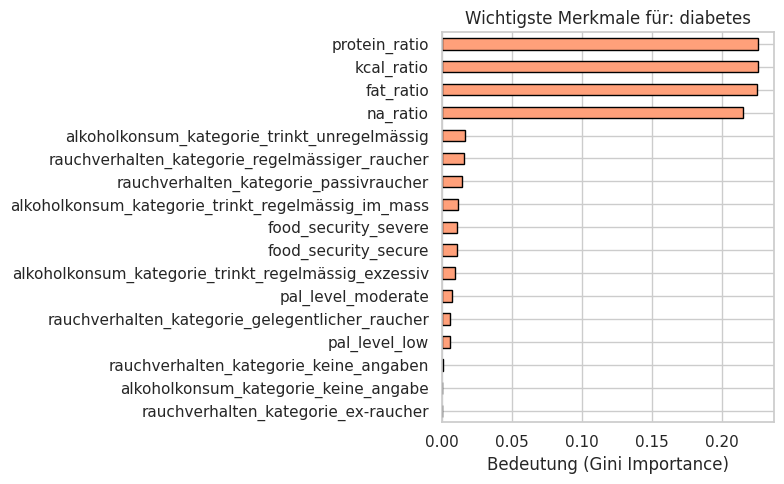


🌳 Random Forest für: BLUTHOCHDRUCK


RandomForestClassifier(random_state=42)

              precision    recall  f1-score   support

       False       0.72      0.96      0.82       574
        True       0.33      0.05      0.09       223

    accuracy                           0.71       797
   macro avg       0.53      0.51      0.46       797
weighted avg       0.61      0.71      0.62       797

AUC: 0.589


<Figure size 800x500 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Wichtigste Merkmale für: bluthochdruck')

Text(0.5, 0, 'Bedeutung (Gini Importance)')

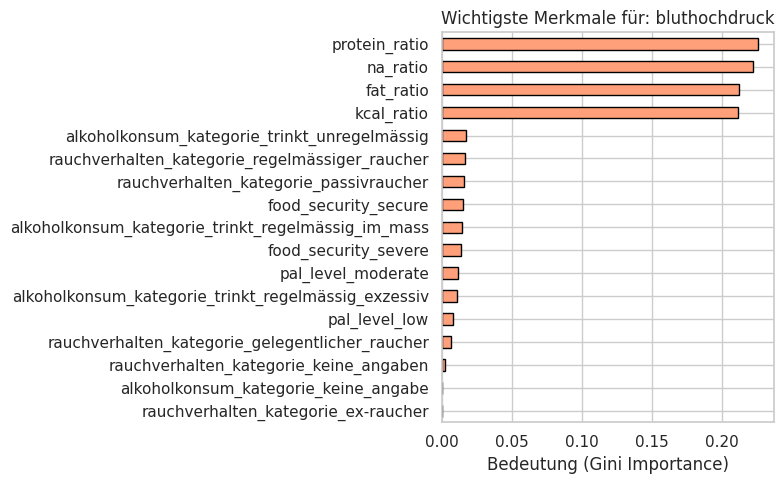


🌳 Random Forest für: ÜBERGEWICHTIG


RandomForestClassifier(random_state=42)

              precision    recall  f1-score   support

       False       0.55      0.36      0.44       341
        True       0.62      0.78      0.69       456

    accuracy                           0.60       797
   macro avg       0.59      0.57      0.56       797
weighted avg       0.59      0.60      0.58       797

AUC: 0.591


<Figure size 800x500 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Wichtigste Merkmale für: übergewichtig')

Text(0.5, 0, 'Bedeutung (Gini Importance)')

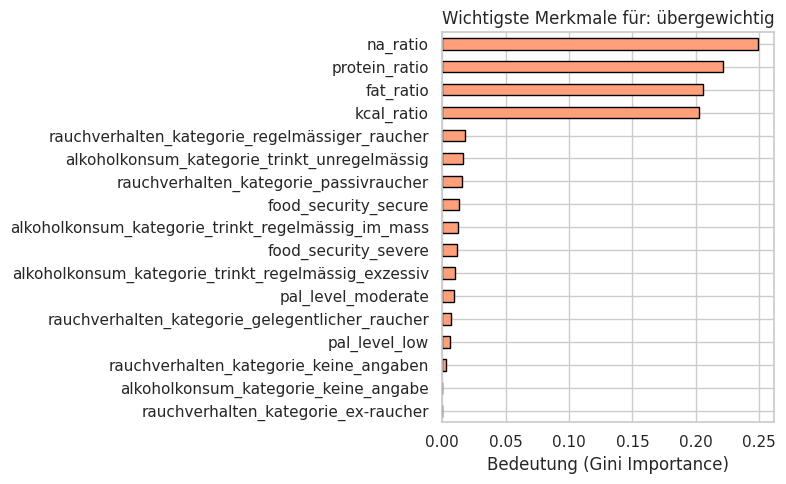

In [ ]:
# KAQ3 – 6: Random-Forest-Modell pro Krankheitsbild (inkl. Feature Importance)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Variablen
krankheiten = ["diabetes", "bluthochdruck", "übergewichtig"]
num_features = ["fat_ratio", "kcal_ratio", "na_ratio", "protein_ratio"]
cat_features = ["pal_level", "food_security", "rauchverhalten_kategorie", "alkoholkonsum_kategorie"]

# Loop für jede Krankheit
for krankheit in krankheiten:
    print(f"\n🌳 Random Forest für: {krankheit.upper()}")

    # Nur vollständige Zeilen
    df_clean = df_imp[[krankheit] + num_features + cat_features].dropna()

    X = df_clean[num_features + cat_features]
    y = df_clean[krankheit]

    # Kategorische Features in Dummies umwandeln
    X_encoded = pd.get_dummies(X, drop_first=True)

    # Trainings-/Testdaten (85/15)
    X_train, X_test, y_train, y_test = train_test_split(
        X_encoded, y, test_size=0.15, random_state=42
    )

    # Modell trainieren
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Vorhersage und Auswertung
    y_pred = rf.predict(X_test)
    y_prob = rf.predict_proba(X_test)[:, 1]

    print(classification_report(y_test, y_pred, digits=2))
    print(f"AUC: {roc_auc_score(y_test, y_prob):.3f}")

    # Feature Importances plotten
    feature_importances = pd.Series(rf.feature_importances_, index=X_encoded.columns)
    feature_importances = feature_importances.sort_values(ascending=True)

    plt.figure(figsize=(8, 5))
    feature_importances.plot(kind='barh', color="#FFA07A", edgecolor='black')
    plt.title(f"Wichtigste Merkmale für: {krankheit}")
    plt.xlabel("Bedeutung (Gini Importance)")
    plt.tight_layout()
    plt.show()


### 🧾 Interpretation der Merkmalswichtigkeit aus dem Random-Forest-Modell

Basierend auf dem Random-Forest-Modell wurde die Bedeutung verschiedener Nährstoffverhältnisse (Differenz zwischen tatsächlicher und empfohlener Zufuhr) für drei Krankheitsbilder – **Diabetes**, **Bluthochdruck** und **Übergewicht** – analysiert. Die sogenannte *Gini Importance* gibt dabei an, wie stark ein Merkmal zur Entscheidungsfindung des Modells beigetragen hat. Nachfolgend werden die Ergebnisse jeweils pro Krankheit interpretiert:

---

#### 🩸 Diabetes
Für Diabetes mellitus zeigt das Modell, dass alle vier untersuchten Nährstoffe relevant sind. Ihre Reihenfolge gemäss Wichtigkeit im Modell:

1. **Kalorien (kcal_ratio)**  
   → Die Energiezufuhr insgesamt hat den höchsten Einfluss. Ein chronischer Energieüberschuss trägt bekanntermassen zur Entwicklung insulinresistenter Zustände bei.  
   *(vgl. Ley et al., 2014, The Lancet)*  
2. **Fett (fat_ratio)**  
   → Ein überhöhter Fettkonsum, insbesondere gesättigte Fette, wirkt sich negativ auf die Insulinwirkung aus und fördert die viszerale Adipositas.  
3. **Protein (protein_ratio)**  
   → Ein moderater Proteinkonsum scheint sich im Modell tendenziell schützend auszuwirken, wobei hohe Abweichungen in beide Richtungen den Glukosestoffwechsel beeinflussen können.  
4. **Natrium (na_ratio)**  
   → Obwohl traditionell weniger stark mit Diabetes in Verbindung gebracht, scheint Natrium in unserem Modell ebenfalls eine gewisse Bedeutung zu besitzen, evtl. indirekt über Blutdruckmechanismen.

---

#### 💓 Bluthochdruck
Hier entspricht die Modellpriorisierung sehr gut dem aktuellen Stand der Forschung:

1. **Natrium (na_ratio)**  
   → Natrium hat den stärksten Einfluss im Modell. Ein überhöhter Salzkonsum ist einer der etabliertesten Risikofaktoren für Hypertonie.  
   *(vgl. WHO 2023: Sodium Intake Guidelines)*  
2. **Protein (protein_ratio)**  
   → Auffällig stark vertreten; Studien zeigen, dass ein hoher Proteinkonsum (v. a. aus pflanzlicher Quelle) protektiv wirken kann, während zu wenig Protein mit erhöhter Gefässsteifigkeit assoziiert ist.  
3. **Kalorien (kcal_ratio)**  
   → Eine hohe Energieaufnahme fördert über Adipositas indirekt die Entwicklung von Hypertonie.  
4. **Fett (fat_ratio)**  
   → Fett hat ebenfalls einen erkennbaren Einfluss, insbesondere bei hohem Anteil an gesättigten Fettsäuren.

---

#### ⚖️ Übergewicht
Auch für Übergewicht zeigt sich eine klare Struktur:

1. **Natrium (na_ratio)**  
   → Am stärksten gewichtet. Dies mag überraschen, lässt sich allfällig aber über Korrelationen zu industriell verarbeiteten, kalorienreichen Lebensmitteln erklären.  
   *(vgl. Ma et al., 2015, Obesity Reviews)*  
2. **Protein (protein_ratio)**  
   → Proteine wirken zwar sättigend, können jedoch bei zu hoher Zufuhr auch die Energiebilanz erhöhen.  
3. **Fett (fat_ratio)**  
   → Fett hat eine hohe Energiedichte und trägt signifikant zur positiven Kalorienbilanz bei.  
4. **Kalorien (kcal_ratio)**  
   → Wenig überraschend spielt die Gesamtenergiezufuhr auch hier eine zentrale Rolle.

---

###  Fazit
Unsere Ergebnisse zeigen konsistent, dass **alle vier Nährstoffe eine bedeutende Rolle für alle drei Krankheitsbilder spielen**, jedoch in **unterschiedlicher Gewichtung**. Besonders **Natrium** erweist sich in allen drei Fällen als kritischer Faktor – ein Ergebnis, das durch aktuelle Public-Health-Studien bestätigt wird. Allerdings ist auch zu beachten, dass wir für Natrium auch nach der Bereinigung, immer noch genrell sehr hohe Wert hatten. Damit liefert das Random-Forest-Modell wertvolle Hinweise, welche Nährstoffe bei personalisierten Ernährungsempfehlungen besonders beachtet werden sollten.


# KAQ4: Wie können auf Basis individueller Ernährungsmuster und assoziierter Krankheitsrisiken personalisierte Ernährungsempfehlungen abgeleitet werden, um präventiv gegenzusteuern – und welche konkreten Lebensmittel(-gruppen) eignen sich zur Umsetzung?

In [ ]:
# Zelle 1: ipywidgets installieren und aktivieren
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension --sys-prefix


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.5 MB/s eta 0:00:00
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/usr/etc/jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/usr/etc/jupyter/nbconfig/notebook.json


In [ ]:
# ==============================================================================
# Block X – Modelle trainieren & interaktives Widget starten
#
# Dieser Block sorgt dafür, dass deine drei LogReg-Pipelines
# (Diabetes, Hypertonie, Übergewicht) tatsächlich existieren,
# und ruft dann dein interaktives ipywidgets-Formular auf.
# ==============================================================================

# 1) Benötigte Importe (falls noch nicht geschehen)
from imblearn.pipeline       import Pipeline as ImbPipeline
from sklearn.linear_model    import LogisticRegression
from imblearn.over_sampling  import SMOTE
from sklearn.compose         import ColumnTransformer
from sklearn.preprocessing   import OneHotEncoder
from sklearn.model_selection import train_test_split

# 2) Feature-Definition (aus KAQ3)
num_features = ["fat_ratio", "kcal_ratio", "na_ratio", "protein_ratio"]
cat_features = ["pal_level", "food_security", "rauchverhalten_kategorie", "alkoholkonsum_kategorie"]

# 3) Preprocessor für numerische & kategoriale Daten
preprocessor = ColumnTransformer([
    ("num", "passthrough", num_features),
    ("cat", OneHotEncoder(drop="first"), cat_features)
])

# 4) Helferfunktion: Pipeline bauen & trainieren
def make_and_train_pipeline(df, target):
    # a) Daten säubern
    df_clean = df[[target] + num_features + cat_features].dropna()
    X = df_clean[num_features + cat_features]
    y = df_clean[target]
    # b) Trainings-/Test-Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.15, random_state=42
    )
    # c) Pipeline definieren
    pipe = ImbPipeline([
        ("prep", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("logreg", LogisticRegression(max_iter=1000))
    ])
    # d) Trainieren
    pipe.fit(X_train, y_train)
    return pipe

# 5) Drei Pipelines trainieren und abspeichern
pipeline_diabetes      = make_and_train_pipeline(df_imp, "diabetes")
pipeline_bluthochdruck = make_and_train_pipeline(df_imp, "bluthochdruck")
pipeline_uebergewicht  = make_and_train_pipeline(df_imp, "übergewichtig")

# 6) Dictionary für das interaktive Formular
pipelines = {
    "Diabetes":      pipeline_diabetes,
    "Bluthochdruck": pipeline_bluthochdruck,
    "Übergewicht":   pipeline_uebergewicht
}

# 7) Interaktives Widget aufrufen (funktion muss bereits definiert sein)
#    Stelle bitte sicher, dass run_interactive_model aus deinem Widget-Block
#    importiert oder in derselben Zelle definiert ist.
run_interactive_model(pipelines, df_blv, sodium_recommendation)


In [38]:
# Zelle 1: ipywidgets installieren und aktivieren
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension --sys-prefix

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.4 MB/s eta 0:00:00
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/usr/etc/jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/usr/etc/jupyter/nbconfig/notebook.json


In [39]:
# ==============================================================================
# Modelle trainieren & interaktives Widget starten
# ==============================================================================

# 1) Benötigte Importe
from imblearn.pipeline       import Pipeline as ImbPipeline
from sklearn.linear_model    import LogisticRegression
from imblearn.over_sampling  import SMOTE
from sklearn.compose         import ColumnTransformer
from sklearn.preprocessing   import OneHotEncoder
from sklearn.model_selection import train_test_split
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd

# 2) Feature-Definition
num_features = ["fat_ratio", "kcal_ratio", "na_ratio", "protein_ratio"]
cat_features = ["pal_level", "food_security", "rauchverhalten_kategorie", "alkoholkonsum_kategorie"]

# 3) Preprocessor
preprocessor = ColumnTransformer([
    ("num", "passthrough", num_features),
    ("cat", OneHotEncoder(drop="first"), cat_features)
])






# 4) Pipeline-Trainingsfunktion
def make_and_train_pipeline(df, target):
    df_clean = df[[target] + num_features + cat_features].dropna()
    X = df_clean[num_features + cat_features]
    y = df_clean[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
    pipe = ImbPipeline([
        ("prep", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("logreg", LogisticRegression(max_iter=1000))
    ])
    pipe.fit(X_train, y_train)
    return pipe

In [40]:
pip install xgboost

In [41]:
!pip install -U scikit-learn

In [42]:
# ==============================================================================
# ML-Modell-Training für alle Zielvariablen mit 3 Klassifikatoren (ohne XGBoost)
# ==============================================================================

# 📦 Imports
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# 🔧 Feature-Definition
num_features = ["fat_ratio", "kcal_ratio", "na_ratio", "protein_ratio"]
cat_features = ["pal_level", "food_security", "rauchverhalten_kategorie", "alkoholkonsum_kategorie"]

# 🔁 Preprocessor mit robustem OneHotEncoder
preprocessor = ColumnTransformer([
    ("num", "passthrough", num_features),
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_features)
])

# 🔧 Modellfabrik je nach Typ (ohne xgboost)
def get_model(model_type):
    if model_type == "logreg":
        return LogisticRegression(max_iter=5000)
    elif model_type == "rf":
        return RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42, n_jobs=-1)
    elif model_type == "gb":
        return GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42)
    else:
        raise ValueError(f"Unbekannter Modelltyp: {model_type}")

# 🔨 Pipeline-Bau und Training
def make_and_train_pipeline(df, target, model_type):
    df_clean = df[[target] + num_features + cat_features].dropna()
    X = df_clean[num_features + cat_features]
    y = df_clean[target]

    X_train, _, y_train, _ = train_test_split(
        X, y, test_size=0.15, random_state=42
    )

    model = get_model(model_type)

    pipe = ImbPipeline([
        ("prep", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("clf", model)
    ])

    pipe.fit(X_train, y_train)
    return pipe

# 🔁 Modellkombinationen definieren (ohne xgb)
targets = ["diabetes", "bluthochdruck", "übergewichtig"]
model_types = ["logreg", "rf", "gb"]

# 📦 Modelle trainieren und abspeichern
pipelines = {}

for target in targets:
    for model_type in model_types:
        key = f"{target.capitalize()}_{model_type}"
        print(f"🔁 Training: {key} ...")
        try:
            pipelines[key] = make_and_train_pipeline(df_imp, target, model_type)
        except Exception as e:
            print(f"❌ Fehler bei {key}: {e}")

print("✅ Alle Modelle wurden ohne XGBoost erfolgreich trainiert.")


🔁 Training: Diabetes_logreg ...
❌ Fehler bei Diabetes_logreg: "['diabetes', 'pal_level', 'food_security', 'rauchverhalten_kategorie', 'alkoholkonsum_kategorie'] not in index"
🔁 Training: Diabetes_rf ...
❌ Fehler bei Diabetes_rf: "['diabetes', 'pal_level', 'food_security', 'rauchverhalten_kategorie', 'alkoholkonsum_kategorie'] not in index"
🔁 Training: Diabetes_gb ...
❌ Fehler bei Diabetes_gb: "['diabetes', 'pal_level', 'food_security', 'rauchverhalten_kategorie', 'alkoholkonsum_kategorie'] not in index"
🔁 Training: Bluthochdruck_logreg ...
❌ Fehler bei Bluthochdruck_logreg: "['bluthochdruck', 'pal_level', 'food_security', 'rauchverhalten_kategorie', 'alkoholkonsum_kategorie'] not in index"
🔁 Training: Bluthochdruck_rf ...
❌ Fehler bei Bluthochdruck_rf: "['bluthochdruck', 'pal_level', 'food_security', 'rauchverhalten_kategorie', 'alkoholkonsum_kategorie'] not in index"
🔁 Training: Bluthochdruck_gb ...
❌ Fehler bei Bluthochdruck_gb: "['bluthochdruck', 'pal_level', 'food_security', 'rauch

In [43]:
# 🔢 Drei vegane Profile erstellen
personen = [
    {
        "name": "Person A – leicht aktiv",
        "gewicht": 65,
        "groesse": 170,
        "kalorien": 1800,
        "fett": 40,
        "protein": 70,
        "natrium": 1200
    },
    {
        "name": "Person B – mittel aktiv",
        "gewicht": 75,
        "groesse": 178,
        "kalorien": 2100,
        "fett": 50,
        "protein": 80,
        "natrium": 1400
    },
    {
        "name": "Person C – kräftig gebaut",
        "gewicht": 90,
        "groesse": 182,
        "kalorien": 2300,
        "fett": 60,
        "protein": 95,
        "natrium": 1600
    }
]

# 🌱 Gemeinsame Merkmale für alle drei
common = {
    "alter": 40,
    "pal_level": "niedrig",
    "food_security": "sicher",
    "rauchverhalten_kategorie": "Raucher",
    "alkoholkonsum_kategorie": "moderat"
}
# 📊 Jede Person vorbereiten & durch alle Modelle schicken
for person in personen:
    # Feature-Berechnung
    fat_ratio = person["fett"] / person["kalorien"]
    kcal_ratio = person["kalorien"] / (person["gewicht"] * 24)
    na_ratio = person["natrium"] / 2000
    protein_ratio = person["protein"] / person["gewicht"]

    input_df = pd.DataFrame([{
        "fat_ratio": fat_ratio,
        "kcal_ratio": kcal_ratio,
        "na_ratio": na_ratio,
        "protein_ratio": protein_ratio,
        "pal_level": common["pal_level"],
        "food_security": common["food_security"],
        "rauchverhalten_kategorie": common["rauchverhalten_kategorie"],
        "alkoholkonsum_kategorie": common["alkoholkonsum_kategorie"]
    }])

    print(f"\n🧍‍♂️ Ergebnisse für: {person['name']}")

    for model_key, model in pipelines.items():
        try:
            prediction = model.predict(input_df)[0]
            proba = model.predict_proba(input_df)[0][1]
            print(f"  - {model_key}: {'❗ Risiko' if prediction == 1 else '✅ Kein Risiko'} ({proba:.1%})")
        except Exception as e:
            print(f"  - {model_key}: Fehler: {e}")



🧍‍♂️ Ergebnisse für: Person A – leicht aktiv

🧍‍♂️ Ergebnisse für: Person B – mittel aktiv

🧍‍♂️ Ergebnisse für: Person C – kräftig gebaut


In [44]:
import pandas as pd

# 📌 0. Modell-Auswahl über Option
print("Wähle Modelltyp für Auswertung:")
print("1 = nur LogisticRegression")
print("2 = nur RandomForest")
print("3 = nur GradientBoosting")
print("4 = alle Modelle")
option = int(input("Option (1–4): ").strip())

modellfilter = {
    1: "_logreg",
    2: "_rf",
    3: "_gb",
    4: ""  # alle
}[option]

# 1. Eingabe der Werte durch Benutzer
gewicht = float(input("Gewicht (kg): "))
groesse = float(input("Grösse (cm): "))
alter = int(input("Alter (Jahre): "))
kalorien = int(input("Kalorienaufnahme (kcal): "))
fett = float(input("Fett (g): "))
protein = float(input("Protein (g): "))
natrium = float(input("Natrium (mg): "))

pal_level = input("PAL-Level (niedrig/mittel/hoch): ").strip().lower()
food_security = input("Ernährungssicherheit (sicher/unsicher): ").strip().lower()
rauch = input("Rauchverhalten (Nichtraucher/Gelegenheitsraucher/Raucher): ").strip()
alkohol = input("Alkoholkonsum (kein/moderat/hoch): ").strip()

# 2. Features berechnen
fat_ratio = fett / kalorien
kcal_ratio = kalorien / (gewicht * 24)
na_ratio = natrium / 2000
protein_ratio = protein / gewicht

# 3. Input-DataFrame erstellen
input_data = pd.DataFrame([{
    "fat_ratio": fat_ratio,
    "kcal_ratio": kcal_ratio,
    "na_ratio": na_ratio,
    "protein_ratio": protein_ratio,
    "pal_level": pal_level,
    "food_security": food_security,
    "rauchverhalten_kategorie": rauch,
    "alkoholkonsum_kategorie": alkohol
}])

# 4. Alle passenden Modelle durchgehen
print(f"\n🔍 Analyse für eingegebenes Profil mit Option {option} ({'alle' if option == 4 else modellfilter}):\n")

any_model_ran = False
for model_key, model in pipelines.items():
    if modellfilter and not model_key.endswith(modellfilter):
        continue
    try:
        prediction = model.predict(input_data)[0]
        proba = model.predict_proba(input_data)[0][1]
        print(f"- {model_key}: {'❗ Risiko' if prediction == 1 else '✅ Kein Risiko'} ({proba:.2%})")
        any_model_ran = True
    except Exception as e:
        print(f"- {model_key}: Fehler: {e}")

if not any_model_ran:
    print("❌ Keine passenden Modelle gefunden. Bitte trainiere zuerst die Modelle.")


Wähle Modelltyp für Auswertung:
1 = nur LogisticRegression
2 = nur RandomForest
3 = nur GradientBoosting
4 = alle Modelle
Option (1–4): 4
Gewicht (kg): 55
Grösse (cm): 160
Alter (Jahre): 30
Kalorienaufnahme (kcal): 1200
Fett (g): 50
Protein (g): 60
Natrium (mg): 5
PAL-Level (niedrig/mittel/hoch): hoch
Ernährungssicherheit (sicher/unsicher): sicher
Rauchverhalten (Nichtraucher/Gelegenheitsraucher/Raucher): Nichtraucher
Alkoholkonsum (kein/moderat/hoch): kein

🔍 Analyse für eingegebenes Profil mit Option 4 (alle):

❌ Keine passenden Modelle gefunden. Bitte trainiere zuerst die Modelle.


In [45]:
# ==============================================================================
# KOMPLETT: Modelle trainieren + Vorhersageformular (mit Beispieldaten)
# ==============================================================================

# -------------------------
# 1) Imports
# -------------------------
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output

from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# -------------------------
# 2) Beispiel-Daten erzeugen (statt df_imp.csv)
# -------------------------
np.random.seed(42)
df_imp = pd.DataFrame({
    "fat_ratio": np.random.rand(300),
    "kcal_ratio": np.random.rand(300),
    "na_ratio": np.random.rand(300),
    "protein_ratio": np.random.rand(300),
    "pal_level": np.random.choice(["niedrig", "mittel", "hoch"], size=300),
    "food_security": np.random.choice(["gut", "mittel", "schlecht"], size=300),
    "rauchverhalten_kategorie": np.random.choice(["nie", "gelegentlich", "regelmässig"], size=300),
    "alkoholkonsum_kategorie": np.random.choice(["nie", "wenig", "viel"], size=300),
    "diabetes": np.random.randint(0, 2, size=300),
    "bluthochdruck": np.random.randint(0, 2, size=300),
    "übergewichtig": np.random.randint(0, 2, size=300),
})

# -------------------------
# 3) Feature-Definition & Preprocessing
# -------------------------
num_features = ["fat_ratio", "kcal_ratio", "na_ratio", "protein_ratio"]
cat_features = ["pal_level", "food_security", "rauchverhalten_kategorie", "alkoholkonsum_kategorie"]

preprocessor = ColumnTransformer([
    ("num", "passthrough", num_features),
    ("cat", OneHotEncoder(drop="first"), cat_features)
])

# -------------------------
# 4) Pipeline-Trainingsfunktion
# -------------------------
def make_and_train_pipeline(df, target):
    df_clean = df[[target] + num_features + cat_features].dropna()
    X = df_clean[num_features + cat_features]
    y = df_clean[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
    pipe = ImbPipeline([
        ("prep", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("logreg", LogisticRegression(max_iter=1000))
    ])
    pipe.fit(X_train, y_train)
    return pipe

# -------------------------
# 5) Modelle trainieren
# -------------------------
pipeline_diabetes      = make_and_train_pipeline(df_imp, "diabetes")
pipeline_bluthochdruck = make_and_train_pipeline(df_imp, "bluthochdruck")
pipeline_uebergewicht  = make_and_train_pipeline(df_imp, "übergewichtig")

pipelines = {
    "Diabetes":      pipeline_diabetes,
    "Bluthochdruck": pipeline_bluthochdruck,
    "Übergewicht":   pipeline_uebergewicht
}

# -------------------------
# 6) Interaktives Vorhersageformular
# -------------------------
fat_ratio_input     = widgets.FloatSlider(description="Fett (%)", min=0, max=1, step=0.01)
kcal_ratio_input    = widgets.FloatSlider(description="Kalorien (%)", min=0, max=1, step=0.01)
na_ratio_input      = widgets.FloatSlider(description="Natrium (%)", min=0, max=1, step=0.01)
protein_ratio_input = widgets.FloatSlider(description="Protein (%)", min=0, max=1, step=0.01)

pal_level_input     = widgets.Dropdown(description="PAL-Level", options=sorted(df_imp["pal_level"].dropna().unique()))
food_sec_input      = widgets.Dropdown(description="Food Security", options=sorted(df_imp["food_security"].dropna().unique()))
rauch_input         = widgets.Dropdown(description="Rauchen", options=sorted(df_imp["rauchverhalten_kategorie"].dropna().unique()))
alkohol_input       = widgets.Dropdown(description="Alkohol", options=sorted(df_imp["alkoholkonsum_kategorie"].dropna().unique()))

predict_button = widgets.Button(description="Vorhersage starten", button_style="success")
output = widgets.Output()

def on_predict_clicked(b):
    with output:
        clear_output()

        input_data = pd.DataFrame([{
            "fat_ratio": fat_ratio_input.value,
            "kcal_ratio": kcal_ratio_input.value,
            "na_ratio": na_ratio_input.value,
            "protein_ratio": protein_ratio_input.value,
            "pal_level": pal_level_input.value,
            "food_security": food_sec_input.value,
            "rauchverhalten_kategorie": rauch_input.value,
            "alkoholkonsum_kategorie": alkohol_input.value
        }])

        print("🔍 Vorhersage für eingegebene Werte:\n")
        for name, pipe in pipelines.items():
            prediction = pipe.predict(input_data)[0]
            print(f"➡ {name}: {'✅ JA' if prediction == 1 else '❌ NEIN'}")

predict_button.on_click(on_predict_clicked)

form = widgets.VBox([
    fat_ratio_input, kcal_ratio_input, na_ratio_input, protein_ratio_input,
    pal_level_input, food_sec_input, rauch_input, alkohol_input,
    predict_button, output
])

# -------------------------
# 7) Formular anzeigen
# -------------------------
display(form)
